# SABBO
Version: 3.0<br>
Contents:<br>
Kaplan-Meier-Curve
Python-Version: 3.11.17


###### tsolve = survivalTime

In [2]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import numpy as np
from numpy import *
from collections import Counter
from scipy.stats import shapiro
import warnings

from scipy import odr, stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

To begin with, the csv file of the QUBO Clustering data is being read in using Pandas. It is passed to a dataframe.

In [3]:
# Read CSV
csv_file = 'QUBOClusteringData.csv'
originDf = pd.read_csv(csv_file)

originDf.head()
    

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


A quick overview of the runtimes that will be dealt with can be given through a standard pandas function. Shown are statistics such as the quartiles, min and max values, mean and the number of values in total.<br>
This gives an overview of the solving times in general. E.g. the longest an algorithm run took (without regarding censored data) is 1443 time intervals (TI). The quickest were 1 TI. Half took 81TI, while the three quarter Quartile is 282.25% already, showing that there are even longer runtimes than 282.25TI expected for 25%.

In [3]:
pd.DataFrame(originDf["tsolve"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
tsolve,5404.0,203.775167,263.192826,1.0,33.0,81.0,282.25,1443.0


### Topic 1: Kaplan-Meier-Curve
According to Rich et. al (2014) the Kaplan-Meier-Curve originates from Survival-Time analysis. Therefore, the method is used in order to estimate the time-to-event. Therefore, a time of beginning is defined, as well as a time of end.<br>
However, Kaplan-Meier is able to deal with incomplete observation. Therefore, the ending time is unknown. Censoring therefore means, that the total survival time for the subject cannot accurately be determined. This might be the case if e.g. the observation period ends before the ending condition is applicable, there is lack of knowledge of what happened, etc.<br>
The estimation of survival-time with Kaplan-Meier-Curve is not of continious nature. Instead, step-wise estimation is used. The estimation calculation is explained in the following with regards to the use-case of runtimes.<br>
<ol>
<li>All data is described as a table. The table holds the index of time from smallest to longest runtime. For each time documented, an algorithm can be documented as well. To begin with, censored data is left out until stated.
<li>The m-column describes, how many algorithms stopped at the point of time. <br>E.g. regarding the Algorithm UEDA at time = 1TI, 9 algorithm runs finished when optimising 5 variables.
<li>The n-column takes on, how many runs were still ongoing. This includes the one that only finished at the time. Therefore, if at time = 2TI 6 algorithm runs of 20 finished, the n-column still takes on 11 (20- 9 at 1TI). However, if at time = 3TI another 3 algorithm runs finished, the n-value is equal to the perceding substraction of all minus all finished runtimes until that time. Therefore, it would be: n(3TI) = 20 - 9 (1TI) - 6 (TI2) = 5
<li>However, now censored data needs to be incorporated. Therefore, a column q is introduced. The censored data point is assigned to the previous time, where the algorithm for the nvars variable has stopped.
<li>The survival rate S(t) is then calculated by (n-m)/n
<li>The actual value is S(t) multiplied by the previous value (in the cell above).
<li>If a censored data point occured at the time, it needs to be taken out of the calculation of (n-m)/n * [previous cell] by simply subtracting all n and m by the number of censored data at this time slot.
</ol>

<br><br>
###### Sources: <br>
###### Jason T. Rich, J. Gail Neely, Randal C. Paniello, Courtney C. J. Voelker, D. Phil, Brian Nussenbaum and Eric W.Wang: A Practical Guide to understainding Kaplan-meier curves, Feb 2014<br>doi: 10.1016/j.otohns.2010.05.007
###### https://www.youtube.com/watch?v=L_ziqYhksG8 Data Tab


##### Practical adaption:
This examplary data deals with the runtime of algorithms. Therefore, the time of beginning is defined as 0.0. Whereas the time of end usually takes on the value of the optimisation algorithm finishing its task. The data becomes statistically censored due to the fact, that algorithms might not finish. The reasons were not stated in the data, therefore they are referred to as unknown reasons. However, possible are errors occuring or taking longer than a predefined threshold.<br><br>

##### Data Understanding and Kaplan-Meier-Estimation Approach
The CSV-File of QUBO data contains 7800 rows. Each of them embodies an optimisation algorithm run of either UEDA, RS or GR. The variable tsolve is the variable of time-to-event, embodying the optimisation algorithm having finished or taking on no value at all (censored). The tsolve variable is of type float, the algorithm variable var of type string and all others of type integer.<br>
For an easy read, the data is described in bullet points:
<li>Each optimisation algorithm optimises between 5 to 30 variables per run
<li>For each of these 5 to 30 variable optimisation, 100 runs per algorithm were conducted
<li>Therefore, a total of 2600 runs per algorithm is available
<li>Algorithms may end after unknown time due to unknown issues
<li>The column runseed displays the used seed in order to create the datapointds on which the optimisation algorithm ran
<br><br>
Note Implementation details:<br>
The seed affects the performance of optimisation algorithm, too. This is due to the fact, that data points might be distributed differently, therefore making it easier for optimisation algorithms to find an optimum solution within the optimisation landscape. The following calculations do not pay attention to that.<br>
However, within the function of creating MNQDf, the slots parameter is implemented. Thereofre, each calculation can be changed to the following:

<li>The first Kaplan-Meier-Curves take the different seed into account and assign the last time depending on the seed. -> Slots
<li>The second Kaplan-Meier-Curves take only the very last time for the number of variables regardless of the seed. -> !Slots
<br>
The following steps were adapted and added to the pre-described, literary approach of Kaplan-Meier:<br>
<li>Before 1: Filter the CSV-File containing all data depending on their nvars value.

In [4]:
# Make the m-n-q Dataframe 
# @Bool Slots=True: with assignment of each seeds highest runtime for nvars
# @Bool Slots=False: the non-Runtimes retrieve the very highest time for nvars
def makeMDict(nvars, alg, slots):
    OrigDf = originDf[(originDf["alg"] == alg) & (originDf["nvars"] == nvars)]
    # Slots:
    if slots:
        maxTSolverPerSeedUEDA = OrigDf[OrigDf["alg"] == alg].groupby("seed")['tsolve'].max().to_dict()

        MNDf = OrigDf[(OrigDf["alg"] == alg) & (OrigDf["nvars"] == nvars)].copy()
        
        for index, row in MNDf.iterrows():
            if pd.isna(row["tsolve"]):
                if pd.isna(maxTSolverPerSeedUEDA[row["seed"]]):
                    maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
                    MNDf.loc[index, "q SeedZeit"] = maxRuntimeOverall
                else:
                    MNDf.loc[index, "q SeedZeit"] = maxTSolverPerSeedUEDA[row["seed"]]
       
        ArgDf = MNDf.set_index("tsolve").sort_index()

        # make mDict
        allTimes = ArgDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))
        return mDict, ArgDf, allTimes, MNDf
    
    # !Slots:
    else:
        ArgDf = OrigDf
        MNDf = OrigDf.copy()
        maxRuntime = max(MNDf["tsolve"])
        MNDf.loc[pd.isna(MNDf["tsolve"]), "q SeedZeit"] = maxRuntime
        MNDf = MNDf.set_index("tsolve").sort_index()

        # make m Dict
        allTimes = MNDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))
        return mDict, ArgDf, allTimes, MNDf

def makeMNQDf(nvars, alg, slots):
    # From here calculate for both in the same manner
    # make qDict
    mDict, ArgDf, allTimes, MNDf = makeMDict(nvars, alg, slots)
    qDict = {key: 0 for key in mDict}
    try:
        values = list(MNDf["q SeedZeit"].dropna())
    except:
        values = []
    for value in values:
        qDict[value] += 1
        
 
    mDf = pd.DataFrame.from_dict(mDict, orient="index", columns=["m Died"])
    qDf = pd.DataFrame.from_dict(qDict, orient="index", columns=["q Censored"])
    dfOverall = pd.merge(mDf, qDf, left_index=True, right_index=True, how="outer")
    
    # make nDict
    totalRuns = len(ArgDf)  # 100
    nCurrent = totalRuns
    nDict = {key: 0 for key in mDict}
    
    a = 1
    for index, row in dfOverall.iterrows():
        if index == 0.0:
            nDict[index] = totalRuns
            nCurrent = totalRuns
            a = a + 1
        else:
            nDict[index] = nCurrent - row["m Died"] - row["q Censored"]
            nCurrent = nDict[index]    
    values = list(nDict.values())
    keys = list(nDict.keys())
    values.append(totalRuns)
    values = sorted(values, reverse=True) # [100, 100, 90, 89, 88, 87, 78, 69, 0]
    values.pop()
    nDict = dict(zip(keys, values))


    nDf = pd.DataFrame.from_dict(nDict, orient="index", columns=["n at Risk"])

    dfOverall = pd.merge(dfOverall, nDf, left_index=True, right_index=True, how="outer")
    MNQDf = dfOverall

    MNQDf["S(t)"] = (MNQDf["n at Risk"] - MNQDf["m Died"])/MNQDf["n at Risk"]
    pDict = {}

    for index, row in MNQDf.iterrows():
        if index == 0.0:
            pDict[index] = row["S(t)"]
            tmp = pDict[index]
        else:
            pDict[index] = tmp * row["S(t)"]
            tmp = pDict[index]
    pDf = pd.DataFrame.from_dict(pDict, orient="index", columns=["p(S(t))"])
    MNQDf = pd.merge(MNQDf, pDf, left_index=True, right_index=True, how="outer")
    MNQDf["nvar"] = nvars

    del mDict, nDict, pDf, tmp, mDf, qDf
    return MNQDf
 
# Plot one Curve     
def plotKaplanMeier(MNQDf):
    plt.plot(MNQDf.index, MNQDf['p(S(t))'], label='p(S(t))')
    plt.title('Kaplan-Meier-Curve')
    plt.xlabel('Time')
    plt.ylabel('S(t)')
    plt.legend()
    plt.show()


# Plot Multiple Kaplan-Meier-Curves into one image
def KaplansPlotter(nvarsList, alg, slots):
    fig, ax = plt.subplots(figsize=(10, 6))

    for var in nvarsList:
        MNQDf = makeMNQDf(var, alg, slots)
        ax.plot(MNQDf['p(S(t))'], label=f'nvar={var}')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Time')
    ax.set_ylabel('Survivors')
    ax.set_title(f'Kaplan-Meier-Curve of {alg}')

    plt.show()


In [5]:
# make multiple ideal curves into one image and plot not-solved ones
nvarsUEDAset = nvarsGRset = nvarsRSset = set()
nseedsUEDAset = nseedsGRset = nseedsRSset = set()

for index, row in originDf.iterrows():
    if row["alg"] == "UEDA":
        nvarsUEDAset.add(int(row["nvars"]))       # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsUEDAset.add(int(row["seed"]))       # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "GR":
        nvarsGRset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsGRset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "RS":
        nvarsRSset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsRSset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

nvarsUEDA = list(nvarsUEDAset)
nvarsGR = list(nvarsGRset)
nvarsRS = list(nvarsRSset)
nseedsUEDA = list(nseedsUEDAset)
nseedsGR = list(nseedsGRset)
nseedsRS = list(nseedsRSset)

In [6]:
MNQDf = makeMNQDf(15, "UEDA", slots=False)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,15
91.0,1,0,100,0.990000,0.99,15
94.0,1,0,99,0.989899,0.98,15
98.0,1,0,98,0.989796,0.97,15
100.0,1,0,97,0.989691,0.96,15


The following curves display the actual points of each Algorithm depending on the number of variables that were optimised. The Kaplan-Meier-Curve has not yet been smoothed/estimated.<br>
Furthermore, it is of interest how differently the curves behave depending on the seed taken into account in the Kaplan-Meier-Curve calculation process. Therefore, the following images were created first of all using the standard approach (slots = False) and taking into account the seed (slots = True). It becomes clear, that the differences are only small. Since this does not neccessarly add to answering the research question, it is displayed, but further investigation is left out. Therefore, all following functions will use the slots variable set to False to create comparability. 

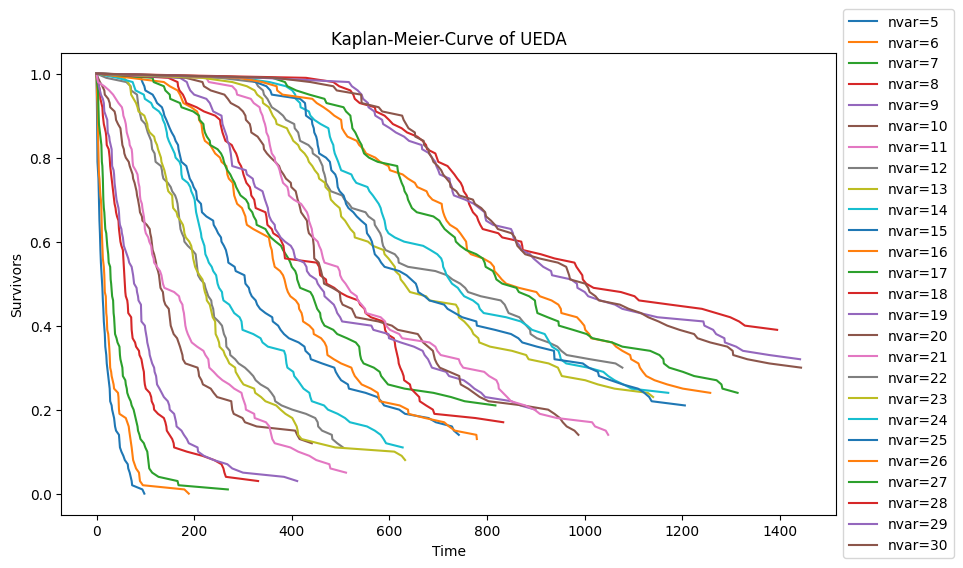

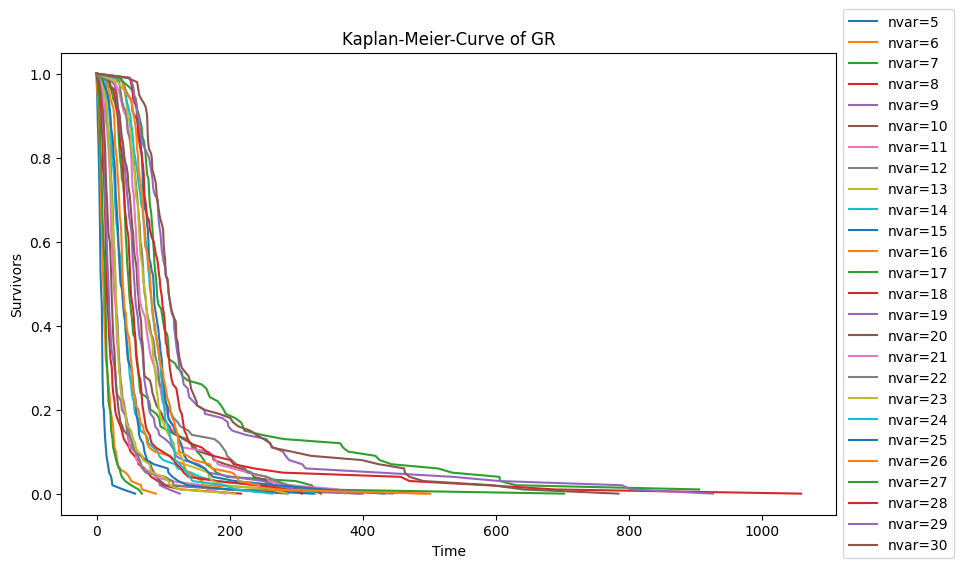

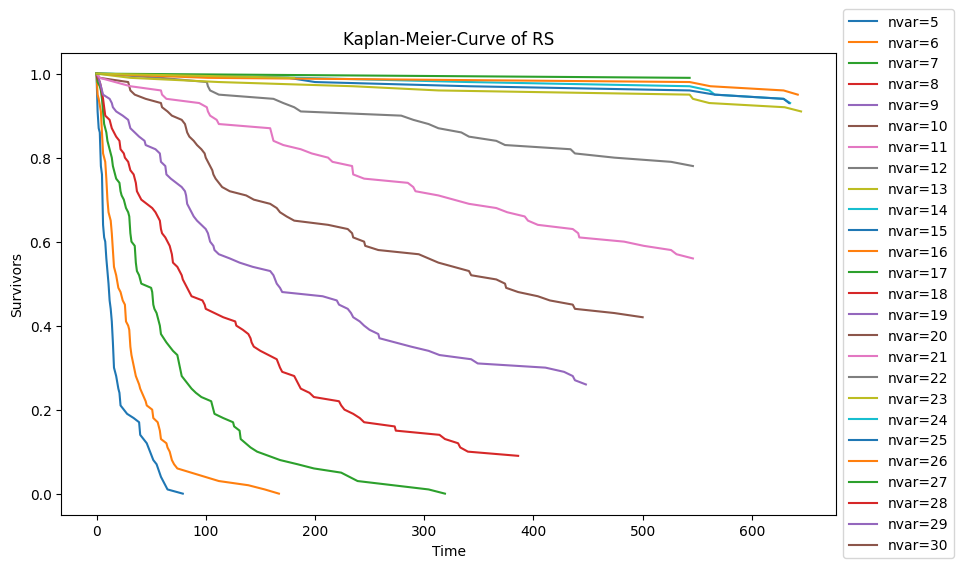

In [7]:
KaplansPlotter(nvarsUEDA, "UEDA", slots=False)
KaplansPlotter(nvarsGR, "GR", slots=False)
KaplansPlotter(nvarsRS, "RS", slots=False)

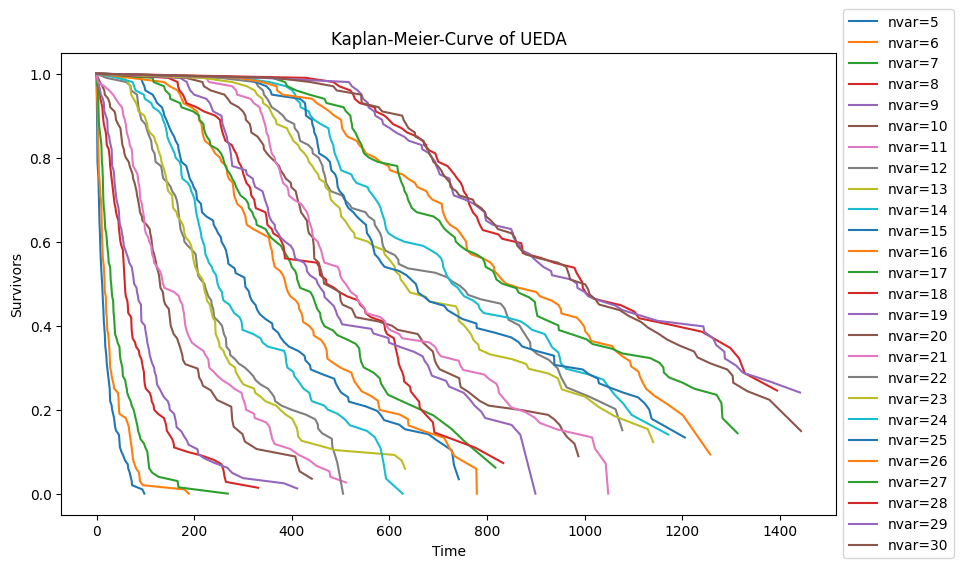

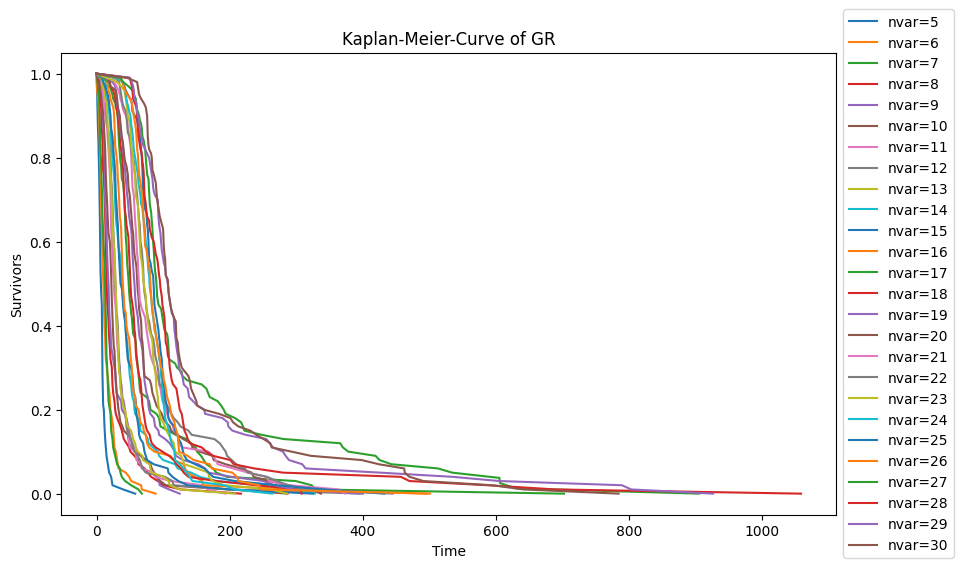

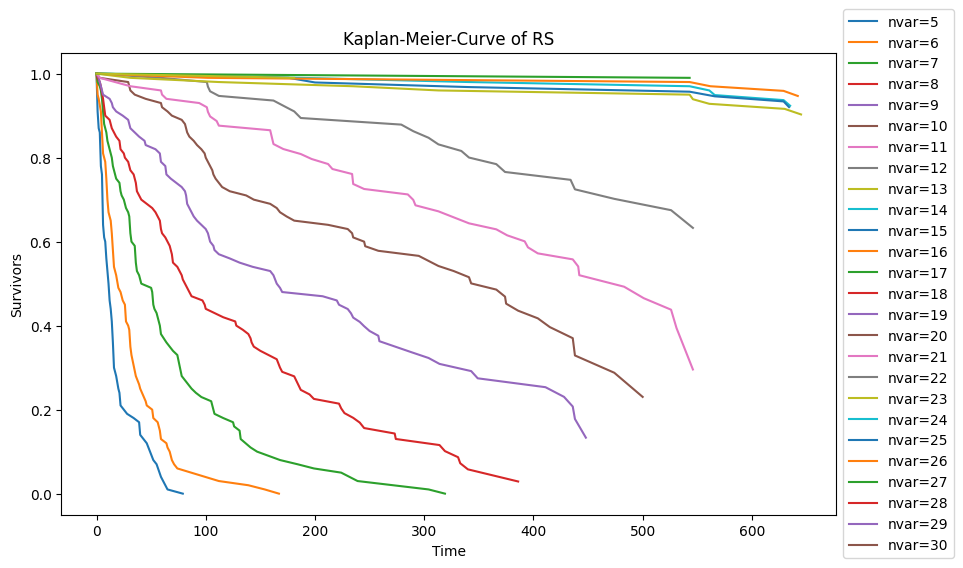

In [8]:
KaplansPlotter(nvarsUEDA, "UEDA", slots=True)
KaplansPlotter(nvarsGR, "GR", slots=True)
KaplansPlotter(nvarsRS, "RS", slots=True)

#### Topic 2: Generating predictions with the Kaplan-Meier-Curve
In this chapter, different ideas of generating predictions of the runtime with the Kaplan-Meier-Curves are investigated. The therefore investigated parameters are the Number of Variables (nvars), Runtime (tsolve) and Algorith (alg).<br>
The first approach is the moving average for time series with different intervals. Therefore, standard distribution is required. The Saphiro Wilk test is going to be implemented in order to evaluate the data distribution. It becomes obvious, that the hypothesis H_0 of standard distribution is refused and therefore this approach will be repudiated.<br>
Then, different mathematical models are used in order to fit each curve. The most common approach is the exponential smoothing out of the Kaplan-Meier-Curves that were displayed before. However, it was displayed, that not all the curves mit fit the exponential model the best. An evaluation will be given after each mathematical model depending on the graphs derived. Each function therefore is supposed to estimate the runtime at a specific point of time for each algorithm and number of optimised variables.

In [9]:
MNQDf = makeMNQDf(10, "UEDA", slots=False)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,10
3.0,1,0,100,0.990000,0.99,10
7.0,1,0,99,0.989899,0.98,10
12.0,1,0,98,0.989796,0.97,10
16.0,1,0,97,0.989691,0.96,10


In [10]:
testDict = {
    'index': [1, 2, 3, 4, 5, 6, 7, 8],
    'p(S(t))': [22, 26, 30, 27, 24, 28, 31, 27],
}

testDf = pd.DataFrame(testDict, index=testDict["index"])
testDf = testDf.drop(columns=["index"])

testDf


,p(S(t))
1,22
2,26
3,30
4,27
5,24
6,28
7,31
8,27


In [11]:
# MNQDf = testDf

def regMovingAvg(MNQDf, windowSize):
    # make dict out of MNQDf
    sliderPointer = 0
    MNQDict = MNQDf['p(S(t))'].to_dict()
    PValDict = list(MNQDict.values())
    SAVal = dict()
    SAResult = []
    summarizer = []
    
    # even windowSize
    if windowSize % 2 == 0:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize+1):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = (1/windowSize) * summarizer[0] + (1/windowSize) * summarizer[len(summarizer)-1]
            del summarizer[0]
            del summarizer[len(summarizer)-1]
            val = val + sum(summarizer)
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    else:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = sum(summarizer) / windowSize
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    # make the format of SAVal the same as for all other columns
    appender = int((windowSize-1)/2)
    for i in range(appender):
        SAResult.append(np.nan)
    for value in SAVal.values():
        SAResult.append(value)
    for i in range(appender):
        SAResult.append(np.nan)

    del summarizer, val, key, SAVal, sliderPointer
    return SAResult


MNQDf["Smoother"] = regMovingAvg(MNQDf, 3)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar,Smoother
0.0,0,0,100,1.000000,1.00,10,NaN
3.0,1,0,100,0.990000,0.99,10,0.99
7.0,1,0,99,0.989899,0.98,10,0.98
12.0,1,0,98,0.989796,0.97,10,0.97
16.0,1,0,97,0.989691,0.96,10,0.96


In [12]:
MNQDf = MNQDf.drop(columns="Smoother")

Unfortunately, the time distribution is anticipated to be irregular; A dependency can be seen nevertheless. For calculating such distribution, it's usually recommended to assume, that all data follows a Standard Distribution in order to calculate irregular, moving averages. In the following, a scrutiny of Standard Distribution is undergone. If applicable, the irregular average function will be shown, elsewise the model will be refused. For evaluation, the Saphiro-Wilk test is used in order to test for normal distribution of time.

In [13]:
# test via Shaphiro-Wilk test for normality
dataRow = MNQDf["p(S(t))"]

stat, pVal = shapiro(dataRow)
alpha = 0.05

if pVal > alpha:
    print("The row of data likely follows a normal distribution.")
else:
    print(f"The row of data has p value of approximately {pVal}.\nIt therefore does not follow a normal distribution.")

The row of data has p value of approximately 0.003407784548539708.
It therefore does not follow a normal distribution.


The Shaphiro-Wilk test has proven, that the moving average with standard distribution will not be suitable in order to smooth the data of the timeseries.<br><br>
The new approach follows fitting different models for each of the Kapplan-Meier-Curves.<br>
The idea behind it is being displayed for UEDA, nvars=7, 13, 21 and 25, slots=False
And GR, nvars=4, 7, 13 and 21 slots= False<br>
First and foremost, the datapoints of each are going to be displayed. Afterwards, the mathmatical models are fitted.

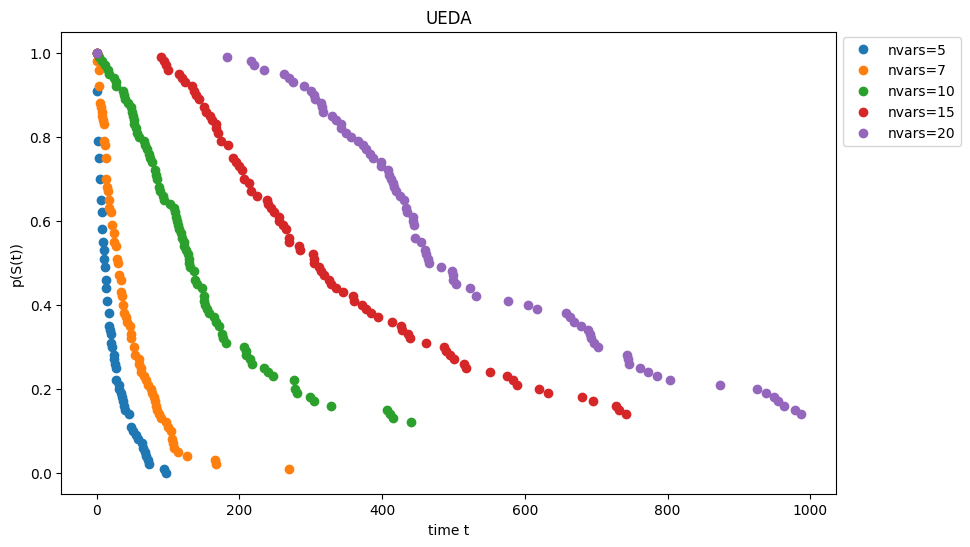

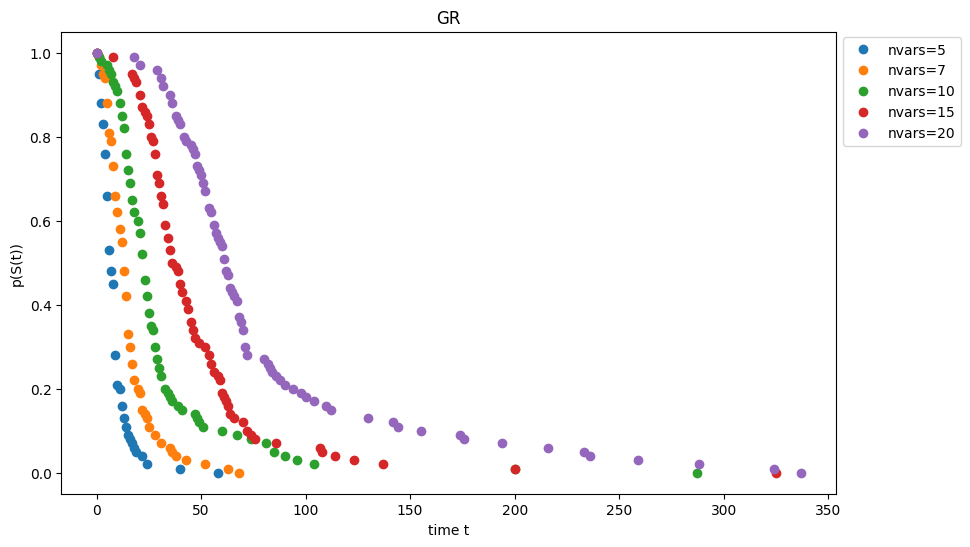

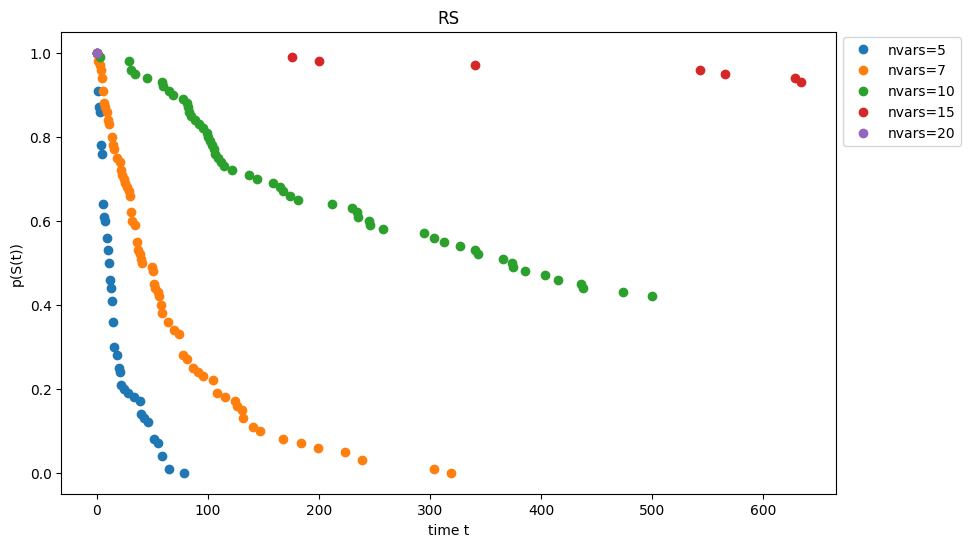

In [14]:
# Hand over array with numbers for each alg
# @Dependency: depends on MakeMNQDf
def plotMaker(arrayo, alg, slots):
    MNQDfDict = dict()
    plt.figure(figsize=(10, 6))
    for nvar in arrayo:
        MNQDf = makeMNQDf(nvar, alg, slots)
        name = f'MNQDf{nvar}{alg}'
        MNQDfDict[name]=MNQDf
        plt.plot(MNQDf.index, MNQDf["p(S(t))"], marker="o", linestyle="None", label=f'nvars={nvar}')

    plt.title(alg)
    plt.xlabel('time t')
    plt.ylabel('p(S(t))')
    plt.grid(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.87))
    plt.show()

    return MNQDfDict

nvars=[5, 7, 10, 15, 20]
UEDADict = plotMaker(nvars, "UEDA", False)
GRDict = plotMaker(nvars, "GR", False)
RSDict = plotMaker(nvars, "RS", False)

In [15]:
MNQDf = makeMNQDf(10, "RS", False)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,10
3.0,1,0,100,0.990000,0.99,10
29.0,1,0,99,0.989899,0.98,10
31.0,2,0,98,0.979592,0.96,10
35.0,1,0,96,0.989583,0.95,10


In [16]:
# @param img: Boolean decides whether an img will be displayed
%matplotlib inline
def doSimpleLinearRegression(ArrMNQDf, alg, img):
        all_errors = []
    
        for dataDict in ArrMNQDf:
                if len(dataDict) > 1:
                        nvar = dataDict["nvar"].iloc[0]
                        x = np.array(dataDict.index)
                        x = x.reshape(-1, 1)
                        y = np.array(dataDict["p(S(t))"])
                        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)
                        reg = LinearRegression().fit(xTrain, yTrain)
                        yPred = reg.predict(xTest)

                        mae = mean_absolute_error(yTest, yPred)
                        mse = mean_squared_error(yTest, yPred)
                        name1 = f"mae{nvar}"
                        name2 = f"mse{nvar}"

                        errorArr = {name1: mae, name2: mse}
                        all_errors.append(errorArr)
                        if img:
                                plt.plot(xTest, yPred, label=f'nvar={nvar}')
                                plt.scatter(x, y)
        if img:
                plt.axhline(y=0, color='black', linestyle='--', label='y=0')
                plt.xlabel('Time')
                plt.ylabel('p(S(t))')
                plt.title(f'{alg} Linear Model')
                plt.legend()
                plt.show()
        
        return all_errors


# Source: https://rowannicholls.github.io/python/statistics/hypothesis_testing/quadratic_regression.html
def doQuadraticRegression(ArrMNQDf, alg, img):
        all_errors = []
        for dataDict in ArrMNQDf:
                if len(dataDict) > 1:
                        nvar = dataDict["nvar"].iloc[0]
                        x = dataDict.index
                        y = dataDict["p(S(t))"]
                        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

                        # Orthogonal distance regression
                        data = odr.Data(x, y)
                        odr_obj = odr.ODR(data, odr.quadratic)
                        output = odr_obj.run()
                        # Sample size
                        n = x.shape[0]
                        # Number of parameters
                        n_params = 3  # We have 3 parameters: α, β and γ
                        # Degrees of freedom
                        dof = n - n_params  # Sample size - number of parameters
                        # Confidence level
                        alpha = 0.05
                        # Two-sided test
                        tails = 2
                        # Percent-point function (aka quantile function) of the t-distribution
                        t_critical = stats.t.ppf(1 - alpha / tails, dof)
                        # Margin of error
                        d = t_critical * output.sd_beta
                        # Confidence interval
                        ci_upper = output.beta + d
                        ci_lower = output.beta - d
                        # Define the parameters
                        symbols = ['γ', 'β', 'α']

                        for i in range(n_params):
                                s = symbols[i]
                                v = output.beta[i]
                                se = output.sd_beta[i]
                                margin = d[i]
                                cu = ci_upper[i]
                                cl = ci_lower[i]
                                print(f'{s} = {v:7.4f} ± {margin:.4f}, 95% CI [{cl:7.04f} to {cu:7.4f}]; se = {se:.4f}')
                                                
                        γ = output.beta[0]
                        β = output.beta[1]
                        α = output.beta[2]


                        # ---------------- get test and train error
                        mae = 0
                        mse = 0
                        a = 0
                        yPred = []

                        for d in xTest:
                                yPreds = α + β * d + γ * d**2
                                yPred.append(yPreds)
                        print(yPreds)

                        for i, y_actual in enumerate(yTest):
                                mae += abs(y_actual - yPred[a])
                                mse += (y_actual - yPred[a])**2
                                a += 1
                        
                        try: 
                                mae /= len(yTest)
                                mse /= len(yTest)
                        except ZeroDivisionError:
                                print("no zero division")
                                return np.nan
                        name1 = f"mae{nvar}"
                        name2 = f"mse{nvar}"

                        errorArr = {name1: mae, name2: mse}
                        all_errors.append(errorArr)

                        # ----------------------------------------



                        if img:
                                # Create the plot
                                plt.scatter(x, y, s=10)
                                # Quadratic line of best fit
                                xlim = plt.xlim()
                                x2 = np.linspace(xlim[0], xlim[1], 100)
                                plt.plot(x2, α + β * x2 + γ * x2**2, label=f'nvar={nvar}')
        if img:
                # Title and labels
                plt.title(f'{alg} Quadratic Regression')
                plt.xlabel('time t')
                plt.ylabel('p(S(t))')
                # Finished
                plt.legend(fontsize=8)
                plt.xlim(xlim)
                plt.show()



        return all_errors


First and foremost, it is begun with simple models. Therefore, Linear Regression and Quadratic Regression are performed on each curve. The result is displayed below.

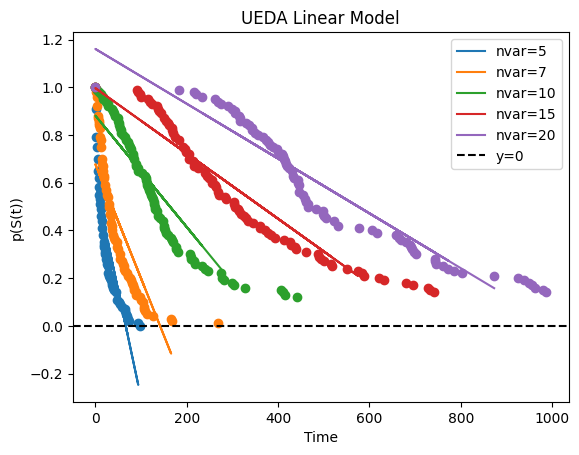

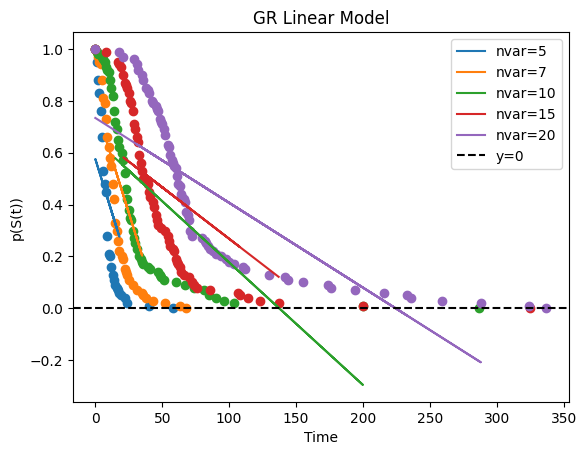

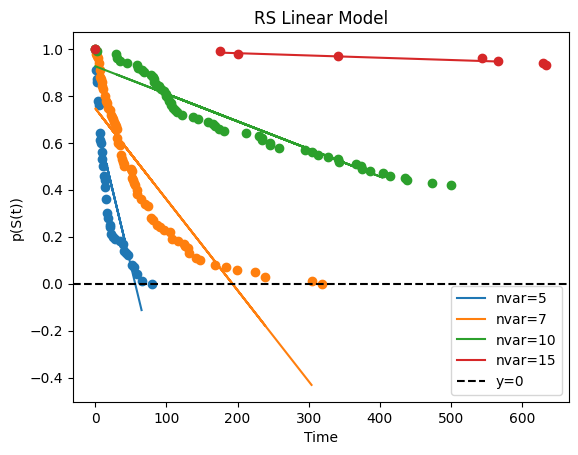

γ =  0.0002 ± 0.0000, 95% CI [ 0.0001 to  0.0002]; se = 0.0000
β = -0.0225 ± 0.0026, 95% CI [-0.0251 to -0.0199]; se = 0.0013
α =  0.7739 ± 0.0451, 95% CI [ 0.7288 to  0.8190]; se = 0.0224
0.6866081766577735
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0112 ± 0.0008, 95% CI [-0.0121 to -0.0104]; se = 0.0004
α =  0.8651 ± 0.0330, 95% CI [ 0.8322 to  0.8981]; se = 0.0165
0.2911146168298274
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0052 ± 0.0002, 95% CI [-0.0054 to -0.0050]; se = 0.0001
α =  1.0697 ± 0.0160, 95% CI [ 1.0537 to  1.0858]; se = 0.0081
0.1708879753855661
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0029 ± 0.0002, 95% CI [-0.0031 to -0.0028]; se = 0.0001
α =  1.2273 ± 0.0293, 95% CI [ 1.1980 to  1.2566]; se = 0.0147
0.5063221330069537
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0019 ± 0.0003, 95% CI [-0.0023 to -0.0016]; se = 0.0002
α =  1.3499 ± 0.0822, 95% CI [ 1.2676 to  

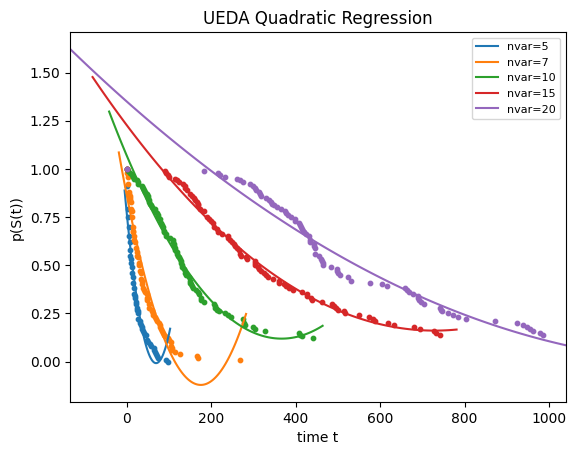

γ =  0.0009 ± 0.0002, 95% CI [ 0.0007 to  0.0011]; se = 0.0001
β = -0.0637 ± 0.0106, 95% CI [-0.0744 to -0.0531]; se = 0.0051
α =  0.9162 ± 0.0994, 95% CI [ 0.8168 to  1.0156]; se = 0.0478
0.31972146731188483
γ =  0.0005 ± 0.0001, 95% CI [ 0.0004 to  0.0006]; se = 0.0000
β = -0.0485 ± 0.0047, 95% CI [-0.0531 to -0.0438]; se = 0.0023
α =  1.0393 ± 0.0563, 95% CI [ 0.9830 to  1.0955]; se = 0.0276
0.22195685325111988
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0001]; se = 0.0000
β = -0.0150 ± 0.0026, 95% CI [-0.0176 to -0.0125]; se = 0.0013
α =  0.8704 ± 0.0840, 95% CI [ 0.7864 to  0.9543]; se = 0.0417
0.5612523370692961
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0138 ± 0.0018, 95% CI [-0.0156 to -0.0119]; se = 0.0009
α =  1.0160 ± 0.0808, 95% CI [ 0.9353 to  1.0968]; se = 0.0402
-0.22368960528220982
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0111 ± 0.0013, 95% CI [-0.0124 to -0.0098]; se = 0.0007
α =  1.1314 ± 0.0749, 95% CI [ 1.0565 

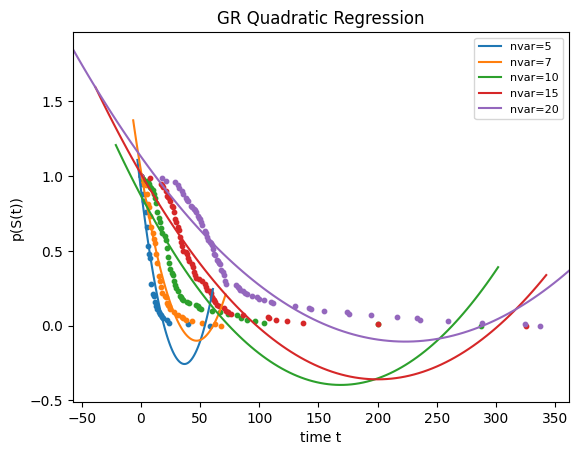

γ =  0.0003 ± 0.0001, 95% CI [ 0.0002 to  0.0003]; se = 0.0000
β = -0.0308 ± 0.0049, 95% CI [-0.0357 to -0.0260]; se = 0.0024
α =  0.8465 ± 0.0620, 95% CI [ 0.7845 to  0.9085]; se = 0.0304
0.32224284543754944
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0086 ± 0.0006, 95% CI [-0.0092 to -0.0080]; se = 0.0003
α =  0.8993 ± 0.0271, 95% CI [ 0.8722 to  0.9264]; se = 0.0136
0.39096678109675853
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0023 ± 0.0002, 95% CI [-0.0025 to -0.0021]; se = 0.0001
α =  1.0171 ± 0.0188, 95% CI [ 0.9983 to  1.0359]; se = 0.0094
0.9477392634392988
γ = -0.0000 ± 0.0000, 95% CI [-0.0000 to  0.0000]; se = 0.0000
β = -0.0001 ± 0.0001, 95% CI [-0.0002 to  0.0001]; se = 0.0000
α =  0.9984 ± 0.0161, 95% CI [ 0.9823 to  1.0145]; se = 0.0063
0.947568842417946


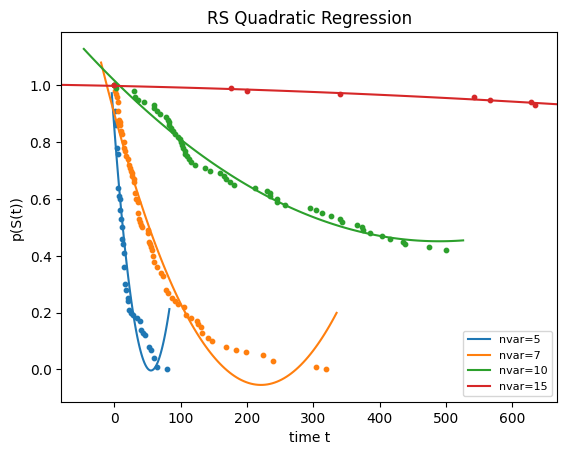

In [44]:
nvars = [5, 7, 10, 15, 20]

dataDictArrayoUEDA = [makeMNQDf(nvar, "UEDA", False) for nvar in nvars]
dataDictArrayoRS = [makeMNQDf(nvar, "RS", False) for nvar in nvars]
dataDictArrayoGR = [makeMNQDf(nvar, "GR", False) for nvar in nvars]

errorsLinearUEDA = doSimpleLinearRegression(dataDictArrayoUEDA, "UEDA", img=True)
errorsLinearGR = doSimpleLinearRegression(dataDictArrayoGR, "GR", img=True)
errorsLinearRS = doSimpleLinearRegression(dataDictArrayoRS, "RS", img=True)

errorsQuadraticUEDA = doQuadraticRegression(dataDictArrayoUEDA, "UEDA", img=True)
errorsQuardraticGR = doQuadraticRegression(dataDictArrayoGR, "GR", img=True)
errorsQuadraticRS = doQuadraticRegression(dataDictArrayoRS, "RS", img=True)

Based on the visual observation, only for the RS model, the linear Regression seems applicable. However, it may not be forgotten, that this can also be due to the fact, that for higher optimised variable numbers few runs are available. Therefore, only few datapoints are fitted thus a simple, linear model can caputure tendencies due to that fact well.<br><br>
The Quadratic model seems to capture the runtimes as long as the minimum of the function is not reached. For most of the points, the runtime would have been over-estimated or under-estimated by little time t. Tendencies such as higher number of optimised variables become obvious already and could help in operational business. The longer the algorithm runs, the worse the performance of the quadratic regression becomes. Therefore its applicablilty depends on the usecase.

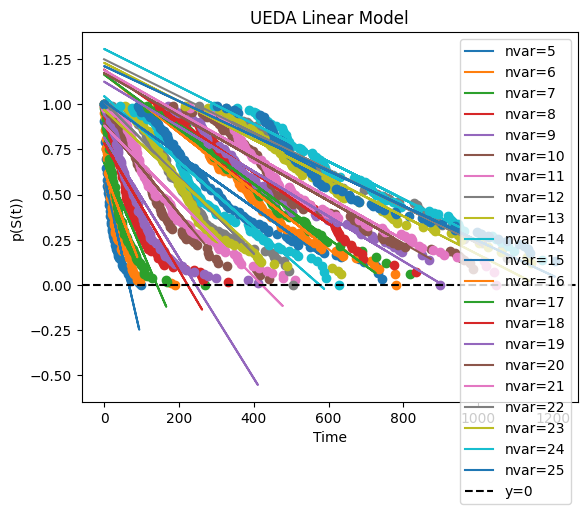

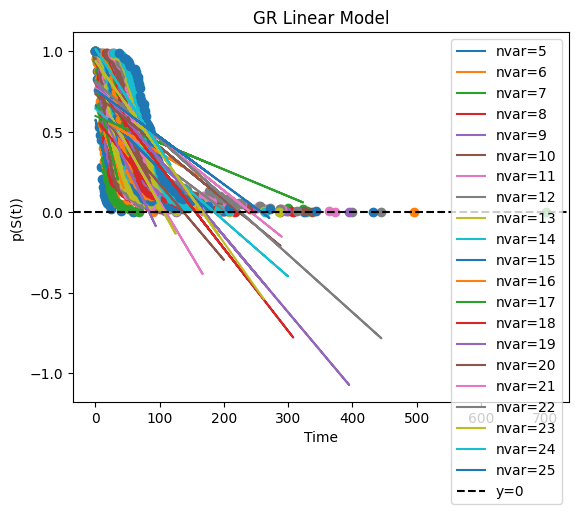

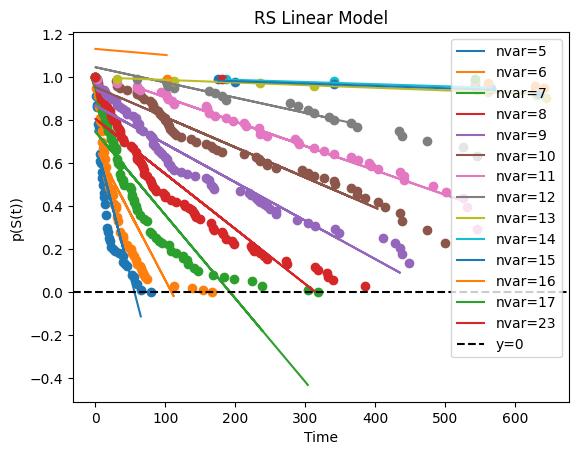

γ =  0.0002 ± 0.0000, 95% CI [ 0.0001 to  0.0002]; se = 0.0000
β = -0.0225 ± 0.0026, 95% CI [-0.0251 to -0.0199]; se = 0.0013
α =  0.7739 ± 0.0451, 95% CI [ 0.7288 to  0.8190]; se = 0.0224
0.6866081766577735
γ =  0.0001 ± 0.0000, 95% CI [ 0.0000 to  0.0001]; se = 0.0000
β = -0.0142 ± 0.0017, 95% CI [-0.0159 to -0.0125]; se = 0.0008
α =  0.7849 ± 0.0476, 95% CI [ 0.7374 to  0.8325]; se = 0.0236
0.40885969309746684
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0112 ± 0.0008, 95% CI [-0.0121 to -0.0104]; se = 0.0004
α =  0.8648 ± 0.0330, 95% CI [ 0.8317 to  0.8978]; se = 0.0165
0.2913556583005959
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0089 ± 0.0004, 95% CI [-0.0093 to -0.0085]; se = 0.0002
α =  0.9912 ± 0.0211, 95% CI [ 0.9701 to  1.0124]; se = 0.0106
0.5612762797036512
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0070 ± 0.0003, 95% CI [-0.0072 to -0.0067]; se = 0.0001
α =  0.9856 ± 0.0170, 95% CI [ 0.9686 to 

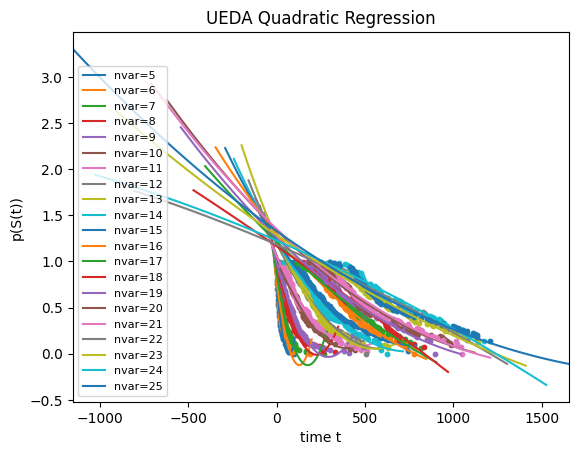

γ =  0.0009 ± 0.0002, 95% CI [ 0.0007 to  0.0011]; se = 0.0001
β = -0.0637 ± 0.0106, 95% CI [-0.0744 to -0.0531]; se = 0.0051
α =  0.9162 ± 0.0994, 95% CI [ 0.8168 to  1.0156]; se = 0.0478
0.31972146731188483
γ =  0.0003 ± 0.0001, 95% CI [ 0.0003 to  0.0004]; se = 0.0000
β = -0.0364 ± 0.0053, 95% CI [-0.0416 to -0.0311]; se = 0.0026
α =  0.8894 ± 0.0757, 95% CI [ 0.8137 to  0.9651]; se = 0.0372
0.26849072260238704
γ =  0.0005 ± 0.0001, 95% CI [ 0.0004 to  0.0006]; se = 0.0000
β = -0.0485 ± 0.0047, 95% CI [-0.0531 to -0.0438]; se = 0.0023
α =  1.0393 ± 0.0563, 95% CI [ 0.9830 to  1.0955]; se = 0.0276
0.22195685325111988
γ =  0.0001 ± 0.0000, 95% CI [ 0.0000 to  0.0001]; se = 0.0000
β = -0.0164 ± 0.0033, 95% CI [-0.0198 to -0.0131]; se = 0.0016
α =  0.8080 ± 0.0919, 95% CI [ 0.7161 to  0.8999]; se = 0.0455
0.6497953926687327
γ =  0.0001 ± 0.0000, 95% CI [ 0.0001 to  0.0002]; se = 0.0000
β = -0.0245 ± 0.0037, 95% CI [-0.0282 to -0.0208]; se = 0.0018
α =  0.9751 ± 0.0790, 95% CI [ 0.8961 t

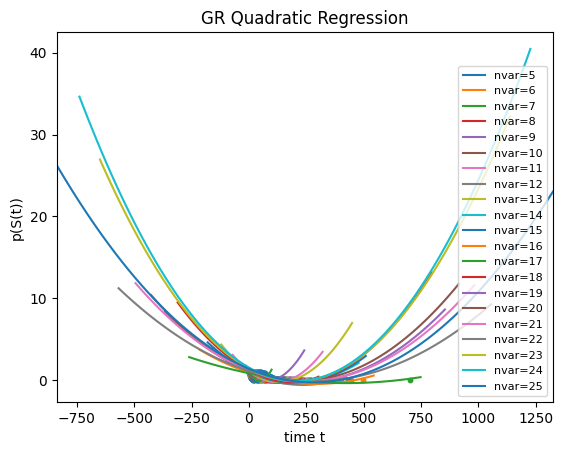

γ =  0.0003 ± 0.0001, 95% CI [ 0.0002 to  0.0003]; se = 0.0000
β = -0.0308 ± 0.0049, 95% CI [-0.0357 to -0.0260]; se = 0.0024
α =  0.8465 ± 0.0620, 95% CI [ 0.7845 to  0.9085]; se = 0.0304
0.32224284543754944
γ =  0.0001 ± 0.0000, 95% CI [ 0.0001 to  0.0001]; se = 0.0000
β = -0.0174 ± 0.0013, 95% CI [-0.0188 to -0.0161]; se = 0.0007
α =  0.8786 ± 0.0354, 95% CI [ 0.8432 to  0.9140]; se = 0.0176
0.39983051582576556
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0086 ± 0.0006, 95% CI [-0.0092 to -0.0080]; se = 0.0003
α =  0.8993 ± 0.0271, 95% CI [ 0.8722 to  0.9264]; se = 0.0136
0.39096678109675853
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0053 ± 0.0003, 95% CI [-0.0055 to -0.0050]; se = 0.0001
α =  0.9291 ± 0.0165, 95% CI [ 0.9127 to  0.9456]; se = 0.0083
0.6014187638932451
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0033 ± 0.0002, 95% CI [-0.0035 to -0.0031]; se = 0.0001
α =  0.9607 ± 0.0175, 95% CI [ 0.9432 t

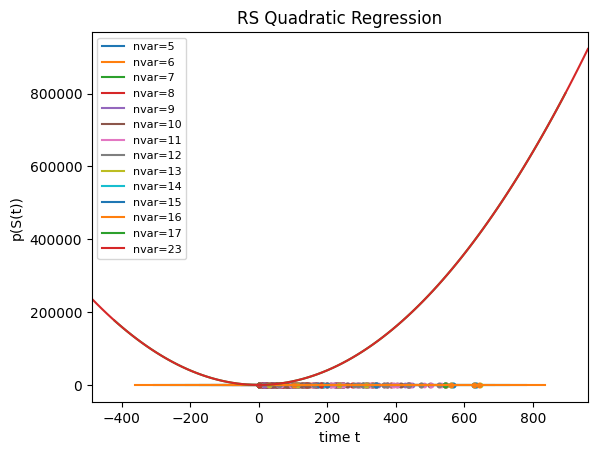

In [18]:
nvars = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

dataDictArrayoUEDA = [makeMNQDf(nvar, "UEDA", True) for nvar in nvars]
dataDictArrayoRS = [makeMNQDf(nvar, "RS", True) for nvar in nvars]
dataDictArrayoGR = [makeMNQDf(nvar, "GR", True) for nvar in nvars]

errorsLinearUEDA = doSimpleLinearRegression(dataDictArrayoUEDA, "UEDA", True)
errorsLinearGR = doSimpleLinearRegression(dataDictArrayoGR, "GR", True)
errorsLinearRS = doSimpleLinearRegression(dataDictArrayoRS, "RS", True)

errorsQuadraticUEDA = doQuadraticRegression(dataDictArrayoUEDA, "UEDA", True)
errorsQuardraticGR = doQuadraticRegression(dataDictArrayoGR, "GR", True)
errorsQuadraticRS = doQuadraticRegression(dataDictArrayoRS, "RS", True)

The models above have shown the estimation of each curve depending on all nvars. Due to the fact, that tendencies appear the same and the images are difficult to interpret at this it is referred to the descriptions above.

In [19]:
print(errorsQuadraticRS)

[{'mae5': 0.0609197813935487, 'mse5': 0.004966784540207409}, {'mae6': 0.06152499238210202, 'mse6': 0.004561636767017006}, {'mae7': 0.052701721468330694, 'mse7': 0.00366439646098139}, {'mae8': 0.02566947206893372, 'mse8': 0.000998800922503818}, {'mae9': 0.024833824221543496, 'mse9': 0.0007356487995755984}, {'mae10': 0.028621294465508304, 'mse10': 0.0010292311677126116}, {'mae11': 0.012233411643910865, 'mse11': 0.00018922414214362965}, {'mae12': 0.013992507449463721, 'mse12': 0.00022409094042802547}, {'mae13': 0.0014545409574350243, 'mse13': 2.216105137020024e-06}, {'mae14': 0.003982319636843701, 'mse14': 1.989166278140228e-05}, {'mae15': 0.0032270799301529762, 'mse15': 1.061946437161985e-05}, {'mae16': 0.007577167453058864, 'mse16': 5.943148439678547e-05}, {'mae17': 295392.01, 'mse17': 87256439571.8401}, {'mae23': 32942.01, 'mse23': 1085176022.8401}]


The values of the mae-Error and mse-error do not follow an actual tendency if only the error rates are looked onto. This is expected to be falsified due to the little availability of datapoints for multiple, optimised nvars. The error therefore is decided upon to not be a good measure if the applicability of model to Kaplan-Meier is evaluated, except if there are sufficient datapoints regarded. A threshold of this was not looked into.<br>
For all models, the following dataframe displays the error values.<br><br>
Furthermore, the error values were visualized, pointing out, which algorithms fail dramatically if nvars was increased. According to that, RS is not suited for the optimisation of higher nvars (>15 or >17 depending on run), therefore, whatever Survival Analysis predicts for that, the error is too far off to actually make any distinctions. Therefore, it can be said that the performance of Survival Analysis depends on the algorithm that undergoes scrutiny. All following examinations will nevertheless be performed on all of the algorithms for the sake of completion.<br>
The error of UEDA is sufficient, as well as the one of GR. It appears that the error values can be taken into account in order to predict a span of which each algorithm might continue on running for the time. E.g. The MSE of UEDA seems stable mostly for all nvars. If nvar = 22 is subject to be estimated, Survival Analysis will get pretty close to the actual time that UEDA is expected to run. In regards to GR, more data could increase the performance of Survival Analysis but it appears to hold potential similar to UEDA in order to make the prediction despite left censored data. As to say, the fewer datapoints there are for higher nvars, the more accurate it might appear. Therefore, this is preliminary result but regarded as "better than no estimation at all".

##### Evaluation of Simple Models


In [20]:
tmpDf1 = tmpDf2 = tmpDf3 = tmpDf4 = tmpDf5 = tmpDf6 = pd.DataFrame()

for dicto in errorsLinearUEDA:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear UEDA'})
    tmpDf1 = pd.concat([tmpDf1, df1], ignore_index=False)
for dicto in errorsLinearRS:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear RS'})
    tmpDf2 = pd.concat([tmpDf2, df1], ignore_index=False)
for dicto in errorsLinearGR:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear GR'})
    tmpDf3 = pd.concat([tmpDf3, df1], ignore_index=False)


for dicto in errorsQuadraticUEDA:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic UEDA'})
    tmpDf4 = pd.concat([tmpDf4, df1], ignore_index=False)
for dicto in errorsQuadraticRS:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic RS'})
    tmpDf5 = pd.concat([tmpDf5, df1], ignore_index=False)
for dicto in errorsQuardraticGR:
    df1 = pd.DataFrame.from_dict(dicto, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic GR'})
    tmpDf6 = pd.concat([tmpDf6, df1], ignore_index=False)

errorsOverallDf = pd.concat([tmpDf1, tmpDf2, tmpDf3, tmpDf4, tmpDf5, tmpDf6], axis=1)

pd.set_option('display.max_rows', None)
errorsOverallDf.head()

,Linear UEDA,Linear RS,Linear GR,Quadratic UEDA,Quadratic RS,Quadratic GR
mae5,0.103844,0.106039,0.213947,0.049835,0.060920,0.052754
mse5,0.016093,0.017160,0.063289,0.002724,0.004967,0.004608
mae6,0.143025,0.131448,0.190072,0.086946,0.061525,0.072995
mse6,0.023644,0.020663,0.037802,0.008310,0.004562,0.007319
mae7,0.139490,0.147373,0.200599,0.059397,0.052702,0.065086


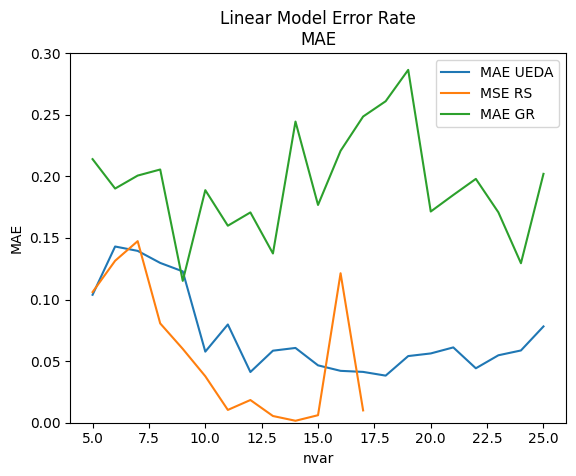

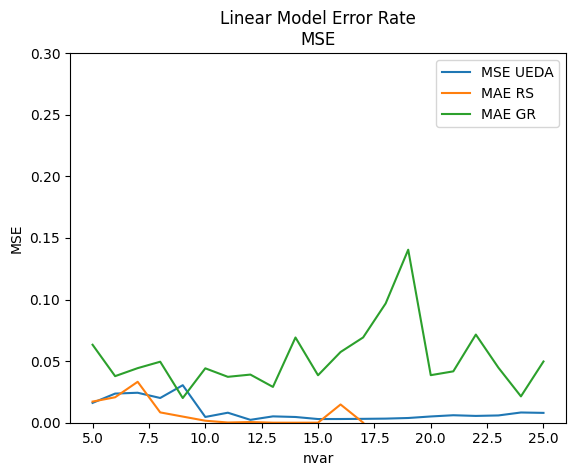

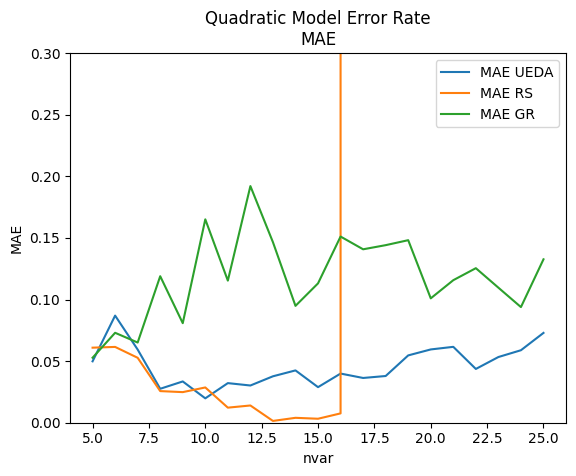

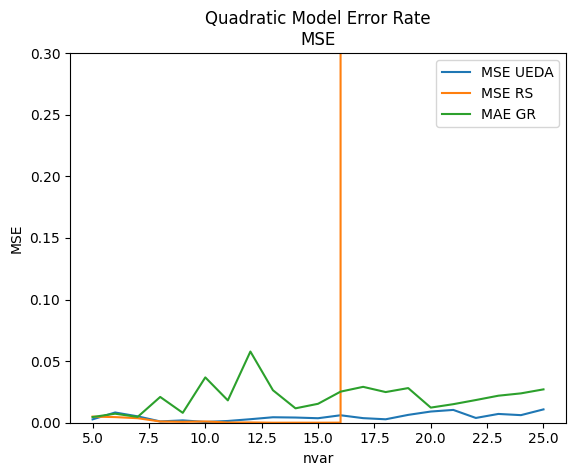

In [21]:
# Plotting
mseDf = errorsOverallDf[errorsOverallDf.index.str.contains('mse')]
maeDf = errorsOverallDf[errorsOverallDf.index.str.contains('mae')]

pYs = mseDf.index
index = [int(re.search(r'\d+', pY).group()) for pY in pYs]      # [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
plt.plot(index, maeDf["Linear UEDA"], label="MAE UEDA")
plt.plot(index, maeDf["Linear RS"], label="MAE RS")
plt.plot(index, maeDf["Linear GR"], label="MAE GR")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Linear Model Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()



plt.plot(index, mseDf["Linear UEDA"], label="MSE UEDA")
plt.plot(index, mseDf["Linear RS"], label="MSE RS")
plt.plot(index, mseDf["Linear GR"], label="MSE GR")
plt.ylabel("MSE")
plt.xlabel("nvar")
plt.title("Linear Model Error Rate\nMSE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()


plt.plot(index, maeDf["Quadratic UEDA"], label="MAE UEDA")
plt.plot(index, maeDf["Quadratic RS"], label="MAE RS")
plt.plot(index, maeDf["Quadratic GR"], label="MAE GR")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Quadratic Model Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()


plt.plot(index, mseDf["Quadratic UEDA"], label="MSE UEDA")
plt.plot(index, mseDf["Quadratic RS"], label="MSE RS")
plt.plot(index, mseDf["Quadratic GR"], label="MSE GR")
plt.ylabel("MSE")
plt.xlabel("nvar")
plt.title("Quadratic Model Error Rate\nMSE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()




In [22]:
MNQDf = makeMNQDf(15, "UEDA", slots=True)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,15
91.0,1,0,100,0.990000,0.99,15
94.0,1,0,99,0.989899,0.98,15
98.0,1,0,98,0.989796,0.97,15
100.0,1,0,97,0.989691,0.96,15


Evaluation summarized briefly:<br>
Regarding those very simple models for UEDA, RS and GR, it becomes clear, that Survival Analysis Models are suited for the algorithms UEDA and GR.
While as, RS brings only miserable error rates. Satisfying was especially the quadratic fitting. <br> <br>
Furthermore, It becomes obvious that the error rate is not co-dependant with the number of variables optimized by each algorithm for UEDA and GR. A tendency of greater error can be assumed. However, especially with regards to the middle range [10; 14] most falsified predictions occured. <br>
The scruntiny is falsified by stopped optimization in regards to high nvars. However, the Survival Analysis Curves are still recommended compared to making a guess only.
<br>
Therefore, two more complex models are implemented further to test, whether they could bring an advantage or if Survival Analysis might be suitable with more complex models for RS even.

## Topic 3: Cox Proportional Hazard Model in Survival Analysis

The Cox proportional hazard model, commonly referred to as Cox regression or the Cox model, is a statistical method widely applied in survival analysis. It proves especially valuable when examining the impact of multiple variables on survival outcomes.

### Methodological Approach

The Cox proportional hazard model works based on the assumption that the hazard function (risk of an event occurring) for an individual is a product of two components: a baseline hazard function and the exponential function of a linear combination of covariates.

#### Key Concepts:

1. **Hazard Function:**
   - The hazard function represents the instantaneous risk of an event occurring at a given time.
   - It is not required to specify the form of the baseline hazard, making the model semi-parametric.

2. **Covariates:**
   - Covariates are the factors or variables that are hypothesized to influence the hazard function.
   - In our analysis, the covariates include the algorithm, nvars (number of variables), seed, and runseed.

3. **Proportional Hazard Assumption:**
   - The model assumes that the hazard ratio between any two individuals remains constant over time.
   - This allows for the comparison of survival curves between different levels of a covariate.

### Application in this chapter

In this chapter, the Cox proportional hazard model is employed to assess the significance of various factors (algorithm, nvars, seed, and runseed) in predicting survival rates. The model enables us to differentiate the strength of influence among these factors.

Further details on the model assumptions, and interpretation of results will be elaborated in subsequent sections.


In [23]:
originDf.head()

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


In [24]:
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter

# Encoding algorithms in numerical values
cdf = originDf.copy()

encoder = LabelEncoder()
cdf['alg'] = encoder.fit_transform(cdf['alg'])

# Creating "event" based on the existence of a solution/time
cdf['event'] = ~cdf['tsolve'].isna()

In [25]:
def replace_nan_values(df, alg):
    df['seed'] = df['seed'].astype(int) 
    maxTSolverPerSeedUEDA = df[df["alg"] == alg].groupby("seed")['tsolve'].max().to_dict()

    for index, row in df.iterrows():
        if pd.isna(row["tsolve"]):
            seed_value = row["seed"]
            if pd.isna(maxTSolverPerSeedUEDA.get(seed_value)):
                maxRuntimeOverall = df['tsolve'].max()
            else:
                maxRuntimeOverall = maxTSolverPerSeedUEDA[seed_value]
                
            df.loc[index, "tsolve"] = maxRuntimeOverall


replace_nan_values(cdf, 'UEDA')
replace_nan_values(cdf, 'RS')
replace_nan_values(cdf, 'GR')

cdf.head()

,tsolve,alg,nvars,seed,runseed,event
0,8.0,2,5,1,1,True
1,7.0,0,5,1,1,True
2,13.0,1,5,1,1,True
3,73.0,2,5,1,2,True
4,4.0,0,5,1,2,True


In [26]:
cph = CoxPHFitter()
cph.fit(cdf, duration_col='tsolve', event_col='event')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7800 total observations, 2396 right-censored observations>
             duration col = 'tsolve'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7800
number of events observed = 5404
   partial log-likelihood = -44166.41
         time fit was run = 2024-02-22 11:41:33 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
alg       -0.81      0.45      0.02           -0.85           -0.76                0.43                0.47
nvars     -0.10      0.90      0.00           -0.11           -0.10                0.90                0.91
seed       0.01      1.01      0.00           -0.00            0.02                1.00                1.02
runseed   -0.00      1.00      0.00           -0.01            0.01                0.99                1.01

           cmp to      z      p  -log2(p)
covariate                                
alg          0.00 -35.92 <0.005    936.32
nvars        0.00 -45.92 <0.005       inf
seed         0.00   1.85   0.06      3.95
runseed      0.00  -0.09   0.93      0.10
---
Concordance = 0.76
Partial AIC = 88340.83
log-likelihood ratio test = 3376.45 on 4 df
-log2(p) of ll-ratio test = inf

## Evaluation:

The evaluation of the Cox proportional hazard model yields insightful findings regarding the factors influencing the survival rate in the context of the analysis.

### Key Observations:

1. **Algorithmic Impact:**
   - The analysis prominently highlights the algorithmic choice as the most influential factor affecting the survival rate.
   - Different algorithms demonstrate substantial variations in their impact on the time taken to find a solution.

2. **nvars (number of variables):**
   - The second most impactful factor is the number of variables (nvars).
   - A noteworthy observation is that a one-unit increase in the number of variables leads to a considerable extension in the time required to find a solution. Specifically, an increase of one variable results in a 10% prolongation in the solution-finding process.

3. **Seed and Runseed Influence:**
   - In contrast, both seed and runseed exhibit negligible influence on the survival rate, as indicated by their associated p-values.
   - The statistical insignificance suggests that variations in seed and runseed do not significantly impact the time to find a solution.

## Topic 4: Dealing with very few successful runs
#### SWPM (Sliding Window Method Based on Predictive Model Imputation)
##### Key Points
- The sliding window method includes a fixed window size of the data distinguishes it from other locally with.
- This local operation feature on sensor window sets with mixed variable provides new SWPM method, combined with PM and predictive model (PM), provides more flexibility than the conventional PM method.
- Modeling technique can be determined according to linearity or nonlinearity properties of the data.

### Methodology
The SWPM methodology can be described in a similar way to CPM. Assume that the data pairs $(v_j,t_j) ; j = 1,...,n$ are the uncensored part of the data. In the sliding window method, for window size $w$ and window both variable vectors can be written as:

$$
t^*_r = (t_r,t_{r+1},...t_{r+w-1})^T \\
V_r = (v_r,v_{r+1},...,v_{r+w-1})^T
$$

where $t^*_r$ and $V_r$ are vectors of the observations in $r^{th}$ window. As $r$ increases, the specified window slides in the data stream. The number of windows changes according to window size $(w)$ and can be calculated as $(n - w + 1)$. Therefore, in the SWPM approach, the number of windows $(w)$ denotes the number of models to be estimated. The method involves censoring levels and regression models, specifically the OLS method and SWPM model. When the censoring level increases, “u” gets small values and takes large values otherwise. Once the parameters of the SW have been determined, the OLS method is applied to the observations in each window. The obtained linear models are then used to impute the right-censored observations. Thus, each censored observation can be estimated with different regression models that provide a local approach to the data points.

The SWPM model can be written as follows:

$$
t^*_r = v_r \beta_r + e_r, \quad r=1,2,…n_w
$$

where $ \beta_r = (\beta_{1r}, \beta_{2r},… ,\beta_{pr})^T $ is the regression coefficient for the $r$-th window and $e_r \sim N(0,\sigma^2)$. From this, the estimator $ \hat{\beta}_r $ of regression coefficients for each window can be estimated similarly to Eq. (4), in the following manner,

$$
\hat{\beta}_r = (v_r^T v_r)^{-1}v_r^T t^*_r
$$

and the fitted values are given by

$$
\hat{t}_r = v_r \hat{\beta}_r = H_t t^*
$$

where $H_t$ is the hat matrix that can be described as $H_t = v_r(v_r^T v_r)^{-1}v_r^T$. It seems that right-censored observations can be imputed by the obtained models. For example, if the $q$-th observation is censored, it can be obtained as follows:

$$
x^{sw}_q = v_q \hat{\beta}_{(q)}
$$


In [27]:
# Read the CSV file
csv_file = 'QUBOClusteringData.csv'
df = pd.read_csv(csv_file)

In [28]:
def swpm_imputation(t, delta, v, w):
    # Initialize the imputed dataset
    x_sw = np.zeros_like(t)

    # Convert delta to a pandas Series if it's a NumPy array
    if isinstance(delta, np.ndarray):
        delta = pd.Series(delta)

    # Obtain the uncensored part of the data
    for i in range(min(len(t), len(delta))):
        if delta.iloc[i].item() == 1:
            x_sw[i] = t[i]

    # Determine the number of windows
    n_w = min(len(t), len(delta)) - w + 1

    # Loop over each window
    for j in range(n_w):
        # Estimate beta for the j-th window
        # This is a placeholder as the actual estimation would depend on your data
        beta_j = np.max(v[j:j+w])

        # Obtain the fitted values for the j-th window
        x_aj_w = v[j] * beta_j

        # Replace censored ones by imputed value
        if delta.iloc[j] == 0:
            x_sw[j] = x_aj_w

    return x_sw



In [29]:
UEDA_df = df[(df['alg'] == 'UEDA')]
GR_df = df[(df['alg'] == 'GR')]
RS_df = df[(df['alg'] == 'RS')]

In [30]:
# UEDA_df
UEDA_df['tfilled'] = swpm_imputation(
    UEDA_df['tsolve'].values,
    UEDA_df.loc[np.isnan(UEDA_df['tsolve']), 'tsolve'].values,
    UEDA_df['nvars'].values,
    6
)

# GR_df
GR_df['tfilled'] = swpm_imputation(
    GR_df['tsolve'].values,
    GR_df.loc[np.isnan(GR_df['tsolve']), 'tsolve'].values,
    GR_df['nvars'].values,
    6
)

# RS_df
RS_df['tfilled'] = swpm_imputation(
    RS_df['tsolve'].values,
    RS_df.loc[np.isnan(RS_df['tsolve']), 'tsolve'].values,
    RS_df['nvars'].values,
    6
)


### Topic 5: Log-Rank-Test
The Log Rank Test is a statistical test that compares the survival times of two or more groups. It is based on the null hypothesis that there is no difference between the groups in terms of survival. The test statistic is calculated by comparing the observed number of events (deaths or failures) in each group with the expected number under the null hypothesis. The p-value is then obtained from the chi-square distribution with degrees of freedom equal to the number of groups minus one.

We will use the `lifelines` library in Python to perform the Log Rank Test. We will compare the following groups:

- UEDA vs GR vs RS for nvars = 10
- UEDA vs GR vs RS for nvars = 20
- UEDA vs GR vs RS for nvars = 30
- UEDA for nvars = 10 vs UEDA for nvars = 20 vs UEDA for nvars = 30
- GR for nvars = 10 vs GR for nvars = 20 vs GR for nvars = 30
- RS for nvars = 10 vs RS for nvars = 20 vs RS for nvars = 30

In [31]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


def compare_groups(groups, labels, title):
  # Initialize the Kaplan-Meier fitter
  kmf = KaplanMeierFitter()
  # Initialize an empty list to store the survival curves
  curves = []
  # Loop through the groups
  for group in groups:
    # Extract the survival time and event indicator
    T = group['tfilled']
    E = ~pd.isna(T)
    # Fit the Kaplan-Meier model
    label = labels.pop(0)
    kmf.fit(T, E, label=label)
    # Append the survival probabilities to the list
    curves.append(kmf.survival_function_[label].values)
  # Ensure the survival probabilities have the same length
  max_length = max(len(curve) for curve in curves)
  curves = [np.pad(curve, (0, max_length - len(curve)), 'edge') for curve in curves]
  # Plot the survival curves
  for curve, label in zip(curves, labels):
    plt.plot(curve, label=label)
    # Set the title, xlabel and ylabel
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.legend()
  # Perform the Log Rank Test
  results = logrank_test(*curves)
  # Print the test summary
  print(results.summary)
  # Return the results
  return results


In [32]:
# Comparisons for UEDA vs GR vs RS for different nvars
nvars_values = [10, 20, 30]

for nvars in nvars_values:
    groups = [UEDA_df[UEDA_df['nvars'] == nvars],
              GR_df[GR_df['nvars'] == nvars],
              RS_df[RS_df['nvars'] == nvars]]
    labels = ['UEDA', 'GR', 'RS']
    title = f'UEDA vs GR vs RS for nvars = {nvars}'
    results = compare_groups(groups, labels, title)
    # Print or use the results as needed

# Comparisons for UEDA for different nvars
nvars_values = [10, 20, 30]

groups_UEDA = [UEDA_df[UEDA_df['nvars'] == nvars] for nvars in nvars_values]
labels_UEDA = [f'UEDA for nvars = {nvars}' for nvars in nvars_values]
title_UEDA = 'UEDA for different nvars'
results_UEDA = compare_groups(groups_UEDA, labels_UEDA, title_UEDA)
# Print or use the results as needed

# Comparisons for GR for different nvars
groups_GR = [GR_df[GR_df['nvars'] == nvars] for nvars in nvars_values]
labels_GR = [f'GR for nvars = {nvars}' for nvars in nvars_values]
title_GR = 'GR for different nvars'
results_GR = compare_groups(groups_GR, labels_GR, title_GR)
# Print or use the results as needed

# Comparisons for RS for different nvars
groups_RS = [RS_df[RS_df['nvars'] == nvars] for nvars in nvars_values]
labels_RS = [f'RS for nvars = {nvars}' for nvars in nvars_values]
title_RS = 'RS for different nvars'
results_RS = compare_groups(groups_RS, labels_RS, title_RS)


   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033
   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033
   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033
   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033
   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033
   test_statistic         p  -log2(p)
0             1.0  0.317311  1.656033


The results of the first Log Rank Test are shown above. The p-values indicate the probability of observing the data under the null hypothesis of no difference between the groups. A small p-value (less than 0.05) suggests that we can reject the null hypothesis and conclude that there is a significant difference between the groups.

- UEDA vs GR vs RS for nvars = 10: The p-value is 0.317311, which means that there is a significant difference between the survival curves of UEDA, GR and RS for nvars = 10.

Log-Rank Test 2 d'Anna<br>
The Log-Rank Test is interested - similar to the Kaplan-Meier-Curve - in the timespan of a starting point S_1 and an Endpoint E_1. Therefore, it is of interest, how likely it is for a state to maintain until a certain point (e.g. patient is alive).<br><br>
Log Rank test tells you, whether there is a difference between to curves.<br>
In other words, if the "difference in curve" has got an influence on the survival time?<br><br>
Null Hypothesis: The curves have the same distribution curve.<br>
p-Value: Is it greater the significance (0.05)? -> No - The Null hypothesis is rejected. Yes - The Null hypothesis is retrained.

In [33]:
originDf.head()

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


The Log-Rank-Test is used in order to compare two or more Kaplan-Meier-Curves

In [34]:
originDf.head()

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


In [35]:
# Make two examples for the same nvars that we are going to compare
MNQDf1 = makeMNQDf(7, "UEDA", slots=True)
MNQDf2 = makeMNQDf(7, "RS", slots=True)
MNQDf3 = makeMNQDf(7, "GR", slots=True)
MNQDf1.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,7
1.0,2,0,100,0.980000,0.98,7
3.0,2,0,98,0.979592,0.96,7
4.0,4,0,96,0.958333,0.92,7
5.0,4,0,92,0.956522,0.88,7


In [36]:
MNQDf3.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,7
1.0,1,0,100,0.990000,0.99,7
2.0,2,0,99,0.979798,0.97,7
3.0,2,0,97,0.979381,0.95,7
4.0,1,0,95,0.989474,0.94,7


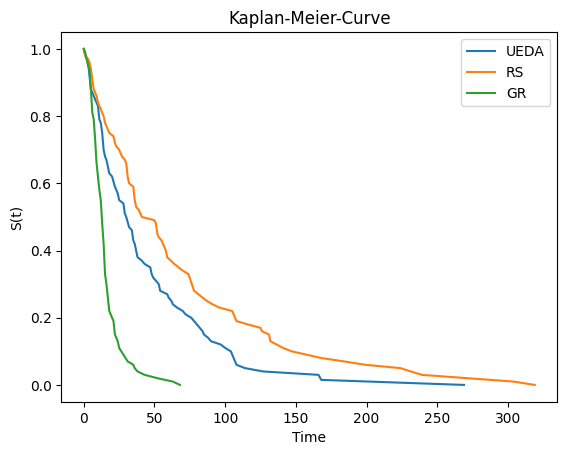

In [37]:
# plot both
plt.plot(MNQDf1.index, MNQDf1['p(S(t))'], label='UEDA')
plt.plot(MNQDf2.index, MNQDf2['p(S(t))'], label='RS')
plt.plot(MNQDf3.index, MNQDf3['p(S(t))'], label='GR')
plt.title('Kaplan-Meier-Curve')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.legend()
plt.show()

H0: There is no significant difference between the curves<br>
H1: There is a siginificant difference between the curves

In [38]:
# Create the lifelines KaplanMeierFitter object for each algorithm
from lifelines import KaplanMeierFitter

In [39]:
# Died of standard function is m in MNQDf
# Time is index

# Perform Log-Rank Test
results = logrank_test(durations_A=MNQDf1.index, durations_B=MNQDf2.index,
                       event_observed_A=MNQDf1['m Died'], event_observed_B=MNQDf2['m Died'])

print(results.summary)

results = logrank_test(durations_A=MNQDf1.index, durations_B=MNQDf3.index,
                       event_observed_A=MNQDf1['m Died'], event_observed_B=MNQDf3['m Died'])

print(results.summary)

   test_statistic         p  -log2(p)
0        2.538201  0.111121  3.169792
   test_statistic         p   -log2(p)
0        23.70583  0.000001  19.764956


## Topic 6: Machine Learning models for time prediction 

### XGBoost Regression

The upcoming section explores the utilization of an XGBoost model, serving as an alternative method for time estimation in comparison to traditional survival analysis.

### Methodology
#### Data Preparation:

The initial step involves data preparation, where missing values in the 'tsolve' column are filled using a specified fill value. The dataset is then split into two subsets: one with complete solutions (df_with_solution) and another with right-censored data (rechtszensierte_daten).

#### Training:

For the df_with_solution subset, an XGBoost regression model is trained on features like 'nvars', 'seed', and 'runseed' to predict the survival time ('tsolve_filled'). The model is trained on a training set and evaluated on a test set using mean squared error (MSE) as the evaluation metric.

#### Prediction:

The trained XGBoost model is then used to predict survival times for the right-censored data (rechtszensierte_daten_filled).

#### Combining Predictions:

Predicted survival times for the right-censored data are combined with the measured survival times ('tsolve') to create a new column ('combined'). This column represents a unified time variable that incorporates both measured and predicted values.

#### Visualization:

Finally, the dataset is sorted based on the combined time variable, and Kaplan-Meier-like curves are plotted for each algorithm. The survival rate is visualized against the combined time, with measured data in red and predicted data in blue.

This methodology provides insights into how well the XGBoost model predicts survival times and allows for a comparison with the traditional survival analysis approach.

In [4]:
df = originDf

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

# data prep

fill_value = -1  
df['tsolve_filled'] = df['tsolve'].fillna(value=fill_value)

df_with_solution = df[df['tsolve_filled'].notnull()]

features = ['nvars', 'seed', 'runseed']

# training

X_train, X_test, y_train, y_test = train_test_split(df_with_solution[features], df_with_solution['tsolve_filled'], test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

# prediction

predictions = model.predict(X_test)


mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


rechtszensierte_daten = df[df['tsolve'].isnull()][features]
rechtszensierte_daten_filled = rechtszensierte_daten.fillna(value=fill_value)
rechtszensierte_vorhersagen = model.predict(rechtszensierte_daten_filled)

df.loc[df['tsolve'].isnull(), 'predicted_tsolve'] = rechtszensierte_vorhersagen

df

Mean Squared Error: 74534.73459875393


,tsolve,alg,nvars,seed,runseed,tsolve_filled,predicted_tsolve
0,8.0,UEDA,5,1,1,8.0,NaN
1,7.0,GR,5,1,1,7.0,NaN
2,13.0,RS,5,1,1,13.0,NaN
3,73.0,UEDA,5,1,2,73.0,NaN
4,4.0,GR,5,1,2,4.0,NaN
...,...,...,...,...,...,...,...
7795,93.0,GR,30,10,9,93.0,NaN
7796,NaN,RS,30,10,9,-1.0,287.585358
7797,681.0,UEDA,30,10,10,681.0,NaN
7798,82.0,GR,30,10,10,82.0,NaN


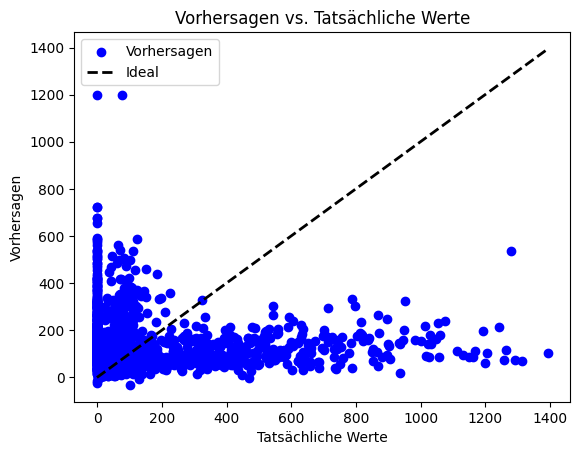

In [5]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions, c='blue', label='Vorhersagen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', linewidth=2, label='Ideal')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhersagen')
plt.title('Vorhersagen vs. Tatsächliche Werte')
plt.legend()
plt.show()

Each point in the plot represents a single instance in the test set. The horizontal distance of each point to the ideal line indicates how far the prediction is from the actual value.
The ideal line represents the perfect prediction, where the predictions correspond exactly to the actual values. 

It is clear that the actual values are often underestimated rather than overestimated. The MSE also appears to be relatively high at 74534.73.


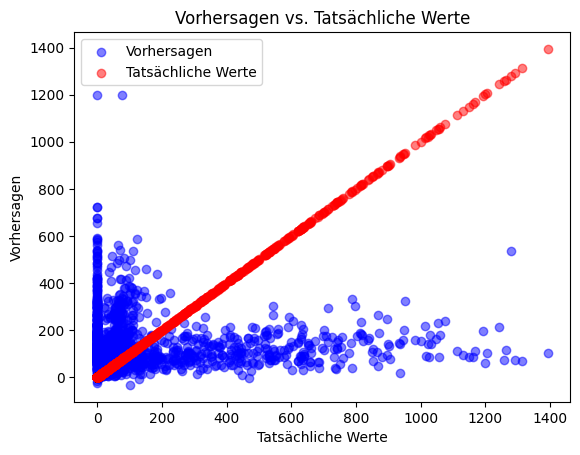

In [6]:
plt.scatter(y_test, predictions, c='blue', label='Vorhersagen', alpha=0.5) 
plt.scatter(y_test, y_test, c='red', label='Tatsächliche Werte', alpha=0.5) 
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhersagen')
plt.title('Vorhersagen vs. Tatsächliche Werte')
plt.legend()
plt.show()


This is another visualization of the same plot.

In [7]:
df_sorted = df.sort_values(by='tsolve')

df_sorted['combined'] = df_sorted['tsolve'].combine_first(df_sorted['predicted_tsolve'])

df_sorted

,tsolve,alg,nvars,seed,runseed,tsolve_filled,predicted_tsolve,combined
220,1.0,GR,5,8,4,1.0,NaN,1.000000
299,1.0,RS,5,10,10,1.0,NaN,1.000000
507,1.0,UEDA,6,7,10,1.0,NaN,1.000000
1113,1.0,UEDA,8,8,2,1.0,NaN,1.000000
108,1.0,UEDA,5,4,7,1.0,NaN,1.000000
...,...,...,...,...,...,...,...,...
7790,NaN,RS,30,10,7,-1.0,340.864868,340.864868
7791,NaN,UEDA,30,10,8,-1.0,115.221992,115.221992
7793,NaN,RS,30,10,8,-1.0,115.221992,115.221992
7796,NaN,RS,30,10,9,-1.0,287.585358,287.585358


All measured and predicted times for the right-censored data points are now displayed below.

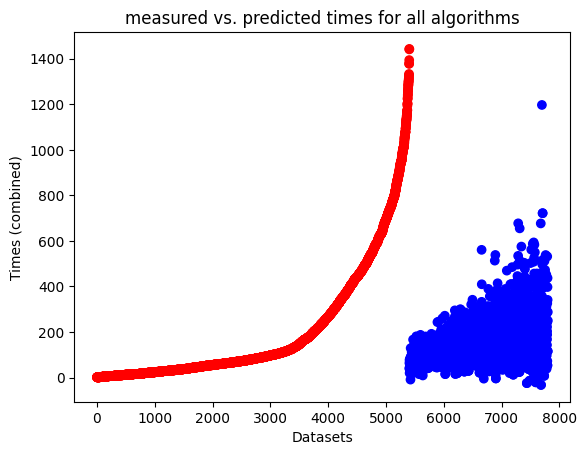

In [8]:
colors = np.where(df_sorted['tsolve'].notnull(), 'red', 'blue')

plt.scatter(range(len(df_sorted)), df_sorted['combined'], c=colors)

plt.xlabel('Datasets')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for all algorithms')
plt.show()

The same visualizations now follow, divided into the three solution algorithms, once sorted by data points and once sorted by the number of variables.

In [9]:
subset_A = df_sorted[df_sorted['alg'] == 'GR']
subset_B = df_sorted[df_sorted['alg'] == 'RS']
subset_C = df_sorted[df_sorted['alg'] == 'UEDA']

#### Greedy Search:

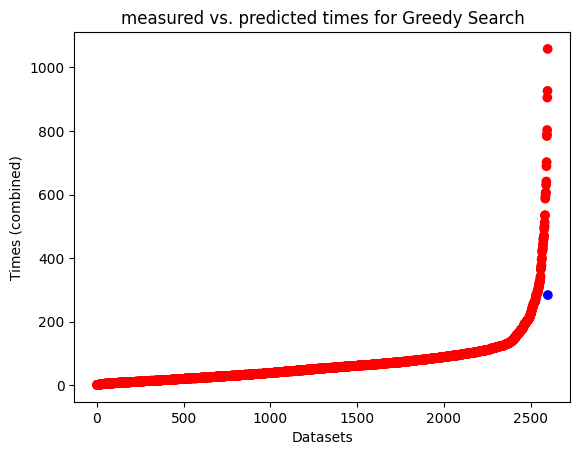

In [10]:
colors = np.where(subset_A['tsolve'].notnull(), 'red', 'blue')

plt.scatter(range(len(subset_A)), subset_A['combined'], c=colors)

plt.xlabel('Datasets')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for Greedy Search')
plt.show()

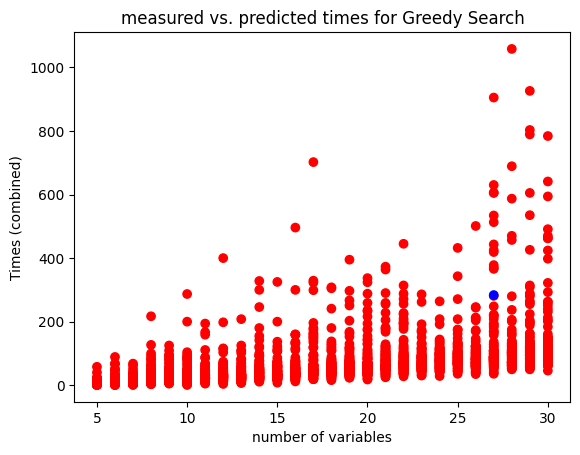

In [10]:
colors = np.where(subset_A['tsolve'].notnull(), 'red', 'blue')

plt.scatter(subset_A['nvars'], subset_A['combined'], c=colors)

plt.xlabel('number of variables')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for Greedy Search')
plt.show()

Greedy Search contains only a very small amount of right-censored data.

#### Random Search:

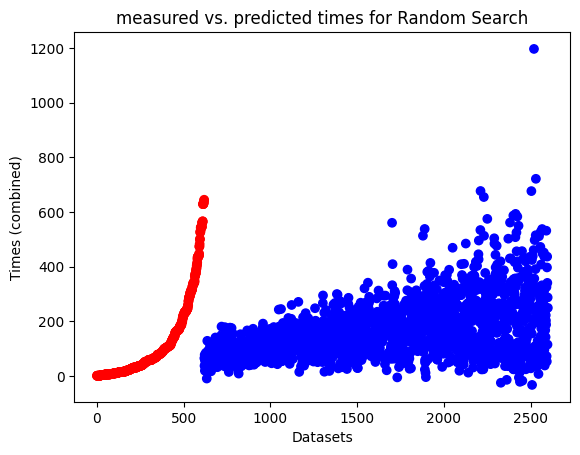

In [11]:
colors = np.where(subset_B['tsolve'].notnull(), 'red', 'blue')

plt.scatter(range(len(subset_B)), subset_B['combined'], c=colors)

plt.xlabel('Datasets')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for Random Search')
plt.show()

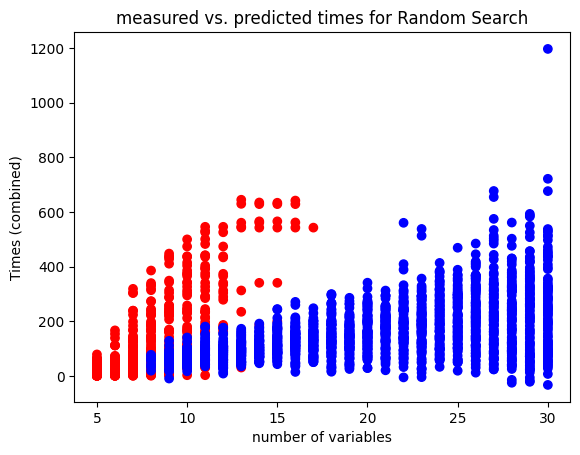

In [12]:
colors = np.where(subset_B['tsolve'].notnull(), 'red', 'blue')

plt.scatter(subset_B['nvars'], subset_B['combined'], c=colors)

plt.xlabel('number of variables')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for Random Search')
plt.show()

Random Search leads to a significantly higher number of right-censored data. The plots illustrate the previous finding that the times are underestimated. It can be seen visually that the predicted times should probably be higher.

#### UEDA:

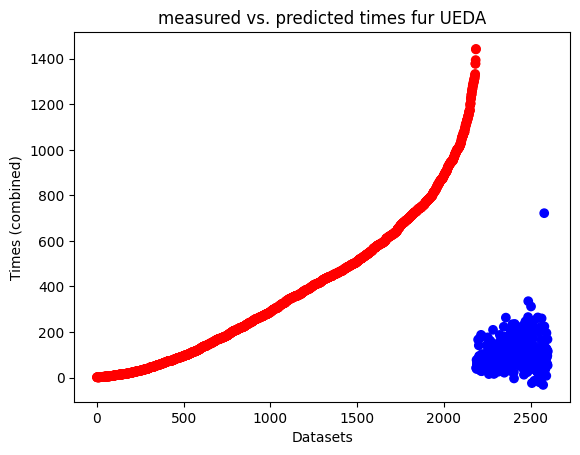

In [13]:
colors = np.where(subset_C['tsolve'].notnull(), 'red', 'blue')

plt.scatter(range(len(subset_C)), subset_C['combined'], c=colors)

plt.xlabel('Datasets')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times fur UEDA')
plt.show()

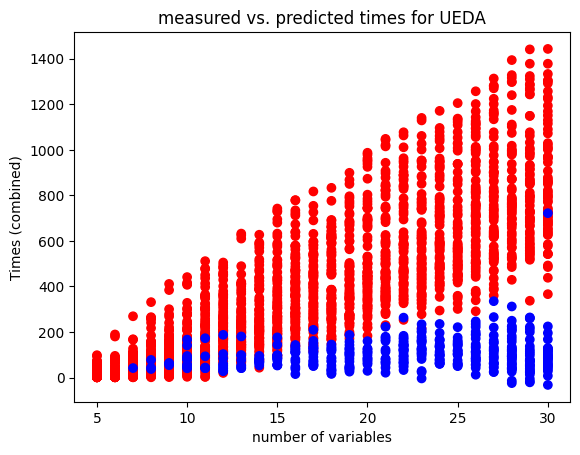

In [14]:
colors = np.where(subset_C['tsolve'].notnull(), 'red', 'blue')

plt.scatter(subset_C['nvars'], subset_C['combined'], c=colors)

plt.xlabel('number of variables')
plt.ylabel('Times (combined)')
plt.title('measured vs. predicted times for UEDA')
plt.show()

The same applies to the predicted times for UEDA.

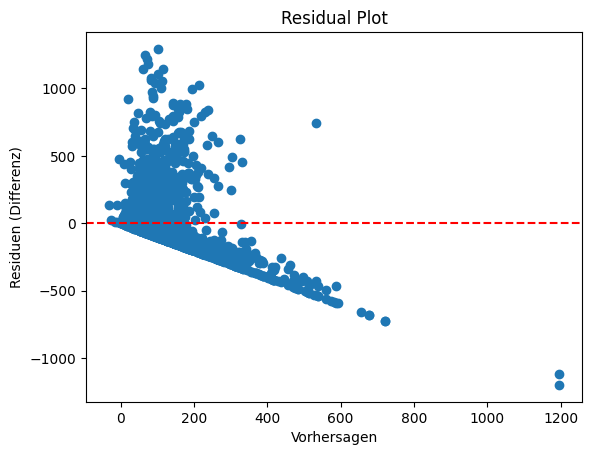

In [15]:
residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.xlabel('Vorhersagen')
plt.ylabel('Residuen (Differenz)')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.show()

Each point in the plot represents a single instance in the test set. The vertical distance of each point from the horizontal line at 0 indicates the size of the residual for this prediction. 
The horizontal line at 0 indicates the reference point where the residuals are zero.

It looks as if more points are being overestimated rather than underestimated.

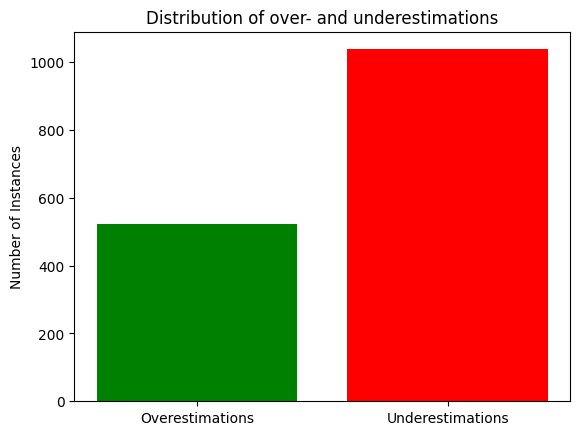

In [16]:
overestimations = residuals[residuals > 0]
underestimations = residuals[residuals < 0]

num_overestimations = len(overestimations)
num_underestimations = len(underestimations)

plt.bar(['Overestimations', 'Underestimations'], [num_overestimations, num_underestimations], color=['green', 'red'])
plt.xlabel('')
plt.ylabel('Number of Instances')
plt.title('Distribution of over- and underestimations')
plt.show()


The plot shows that underestimates predominate

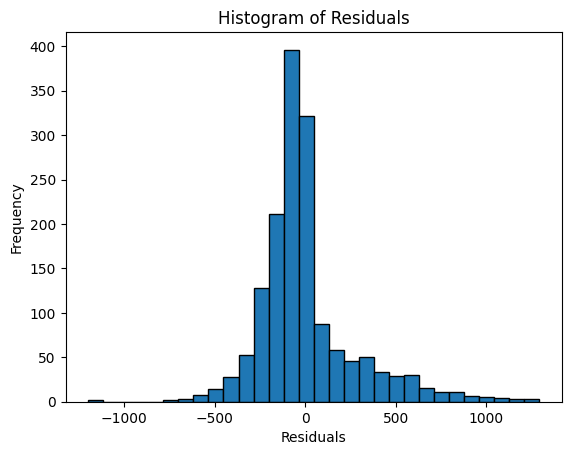

In [17]:
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The histogram shows that the residuals to the left of the zero point occur significantly more frequently, but then fall off. 
This means that overestimated times are very close to the actual time. The situation is different for the underestimates to the right of the zero point. 
These are much more evenly distributed in their frequency of occurrence.

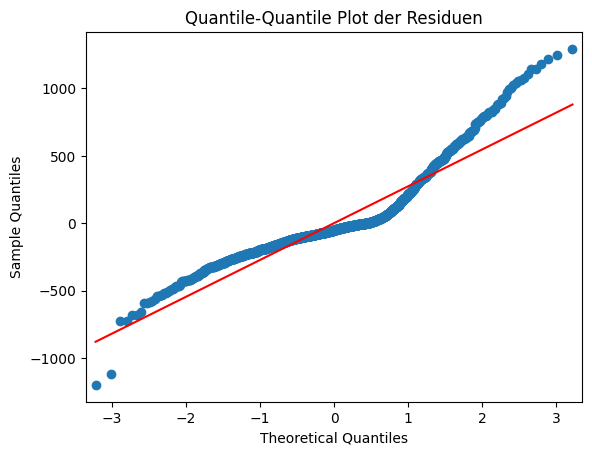

In [18]:
import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.title('Quantile-Quantile Plot der Residuen')
plt.show()

The quantile-quantile (Q-Q) plot is a graphical method for assessing the normality of the residuals. 

Since the points are mostly close to the straight line, this indicates that the residuals follow a nearly normal distribution. The straight line represents the expected quantiles of a normal distribution.

Slight deviations from the straight line (between 0 and 1 and above 2) may indicate that the residuals are not normally distributed there.

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 74534.73459875393
R² Score: -0.2716773034693316


27% of the variance in the dependent variable can be explained by the model.

# Topic 7: Comparison of different approaches

In this section, we visualize and compare the Kaplan-Meier-like curves generated by three different approaches: traditional survival analysis, XGBoost predictions, and a sliding window model.

## Kaplan-Meier Curve for XGBoost Predictions

In [11]:
df_sorted

,tsolve,alg,nvars,seed,runseed,tsolve_filled,predicted_tsolve,combined
220,1.0,GR,5,8,4,1.0,NaN,1.000000
299,1.0,RS,5,10,10,1.0,NaN,1.000000
507,1.0,UEDA,6,7,10,1.0,NaN,1.000000
1113,1.0,UEDA,8,8,2,1.0,NaN,1.000000
108,1.0,UEDA,5,4,7,1.0,NaN,1.000000
...,...,...,...,...,...,...,...,...
7790,NaN,RS,30,10,7,-1.0,340.864868,340.864868
7791,NaN,UEDA,30,10,8,-1.0,115.221992,115.221992
7793,NaN,RS,30,10,8,-1.0,115.221992,115.221992
7796,NaN,RS,30,10,9,-1.0,287.585358,287.585358


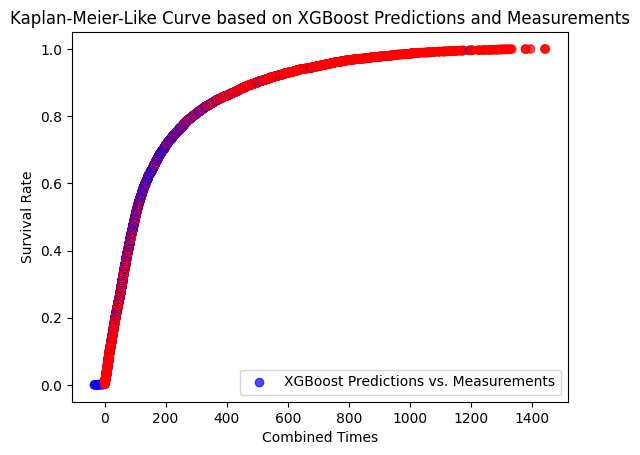

In [12]:
df_sorted = df_sorted.sort_values(by='combined')

df_sorted['survival_rate'] = np.arange(len(df_sorted)) / len(df_sorted)

colors = np.where(df_sorted['tsolve'].notnull(), 'red', 'blue')

plt.scatter(df_sorted['combined'], df_sorted['survival_rate'], c=colors, label='XGBoost Predictions vs. Measurements', alpha=0.7)


plt.xlabel('Combined Times')
plt.ylabel('Survival Rate')
plt.title('Kaplan-Meier-Like Curve based on XGBoost Predictions and Measurements')
plt.legend()
plt.show()


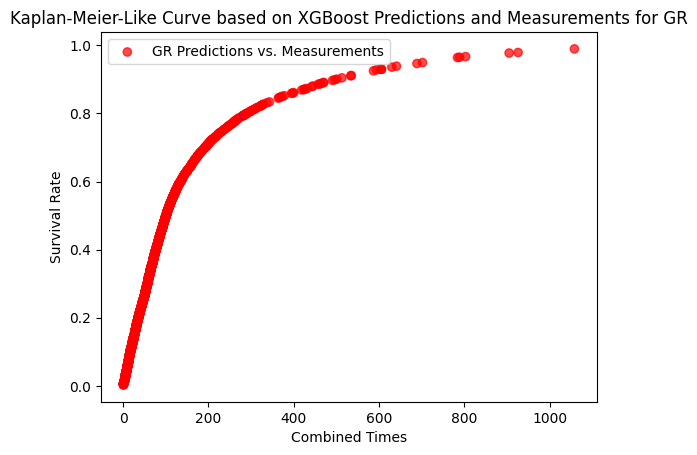

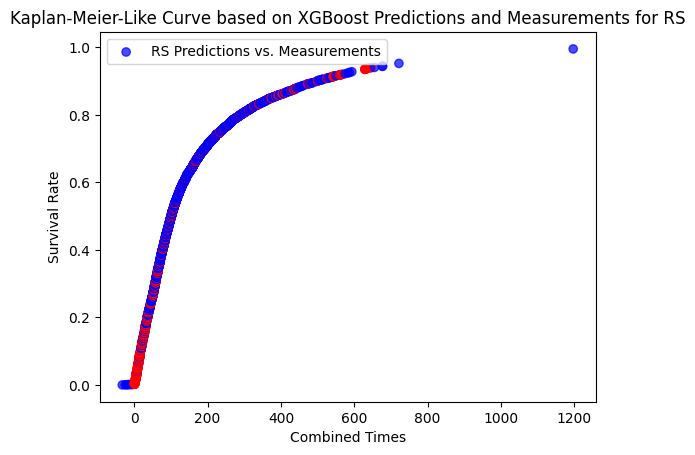

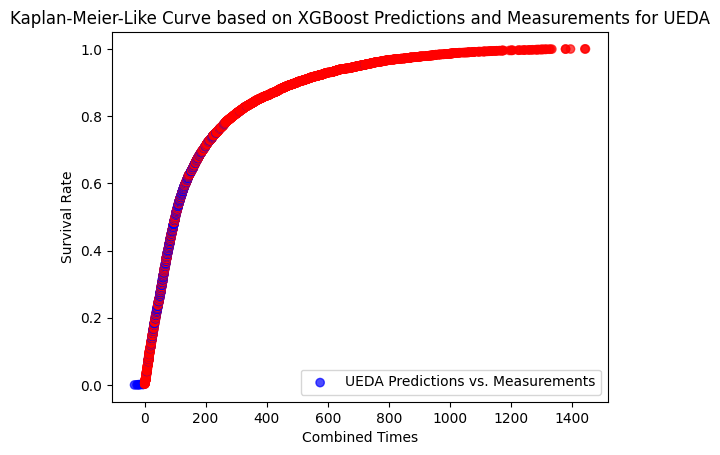

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sort by time to solve
df_sorted = df_sorted.sort_values(by='combined')

# cumulative survivalrate
df_sorted['survival_rate'] = np.arange(len(df_sorted)) / len(df_sorted)

grouped_df = df_sorted.groupby('alg')


for algorithm, group in grouped_df:
    # colors depending on tsolve and predicted_tsolve
    colors = np.where(group['tsolve'].notnull(), 'red', 'blue')

    # cumultaive survivalrate in combined for every alg
    plt.scatter(group['combined'], group['survival_rate'], c=colors, label=f'{algorithm} Predictions vs. Measurements', alpha=0.7)



    plt.xlabel('Combined Times')
    plt.ylabel('Survival Rate')
    plt.title(f'Kaplan-Meier-Like Curve based on XGBoost Predictions and Measurements for {algorithm}')
    plt.legend()
    plt.show()
